## Problem Statement

### Context

AllLife Bank is a US bank that has a growing customer base. The majority of these customers are liability customers (depositors) with varying sizes of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors).

A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns with better target marketing to increase the success ratio.

You as a Data scientist at AllLife bank have to build a model that will help the marketing department to identify the potential customers who have a higher probability of purchasing the loan.

### Objective

To predict whether a liability customer will buy personal loans, to understand which customer attributes are most significant in driving purchases, and identify which segment of customers to target more.

### Data Dictionary
* `ID`: Customer ID
* `Age`: Customer’s age in completed years
* `Experience`: #years of professional experience
* `Income`: Annual income of the customer (in thousand dollars)
* `ZIP Code`: Home Address ZIP code.
* `Family`: the Family size of the customer
* `CCAvg`: Average spending on credit cards per month (in thousand dollars)
* `Education`: Education Level. 1: Undergrad; 2: Graduate;3: Advanced/Professional
* `Mortgage`: Value of house mortgage if any. (in thousand dollars)
* `Personal_Loan`: Did this customer accept the personal loan offered in the last campaign? (0: No, 1: Yes)
* `Securities_Account`: Does the customer have securities account with the bank? (0: No, 1: Yes)
* `CD_Account`: Does the customer have a certificate of deposit (CD) account with the bank? (0: No, 1: Yes)
* `Online`: Do customers use internet banking facilities? (0: No, 1: Yes)
* `CreditCard`: Does the customer use a credit card issued by any other Bank (excluding All life Bank)? (0: No, 1: Yes)

## Importing necessary libraries

In [ ]:
# Installing the libraries with the specified version.
!pip install numpy==1.25.2 pandas==1.5.3 matplotlib==3.7.1 seaborn==0.13.1 scikit-learn==1.2.2 sklearn-pandas==2.2.0 uszipcode==1.0.1 -q --user
!pip install sqlalchemy_mate==1.4.28.4 SQLAlchemy==1.4.32 python-Levenshtein uszipcode==1.0.1

**Note**:

1. After running the above cell, kindly restart the notebook kernel (for Jupyter Notebook) or runtime (for Google Colab), write the relevant code for the project from the next cell, and run all cells sequentially from the next cell.

2. On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

# import all of required libraries and dependecies setting in next code block

In [14]:
# Library to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Data manipulation Libraries
import pandas as pd
import numpy as np

# Library to split data for testing and training model
from sklearn.model_selection import train_test_split

# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Display as many columns in data
pd.set_option("display.max_columns", None)
# Limit number of rows to be displayed to 100 to avoid long list
pd.set_option("display.max_rows", 100)

# Logistic Regression Library
from sklearn.linear_model import LogisticRegression

# Decision Tree Classifier Libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Import Grid Search Model for Exhaustive search over specified parameter values for an estimator.
from sklearn.model_selection import GridSearchCV

# import specific modules from sklearn metrics library
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
    make_scorer,

)

# import the SearchEngine from uszipcode library
# Note - latest uszipcode==1.0.1 has incompatiblity with latest SQLAlchemy and sqlalchemy_mate
# You may need to install dependecies in this sequence to ensure uszipcode library works without error
# pip install sqlalchemy_mate==1.4.28.4
# pip install SQLAlchemy==1.4.32
# pip install uszipcode==1.0.1
# pip install python-Levenshtein

from uszipcode import SearchEngine


## Loading the dataset

In [15]:
# Load data file
data = pd.read_csv("Loan_Modelling.csv")
# Make a copy of the data to avoid any changes to the original data during manipulation
loan = data.copy()

## Data Overview

* Observations
* Sanity checks

In [16]:
# Display 10 random sample rows of the dataset
loan.sample(10)

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
4462,4463,33,7,39,95630,4,0.80,1,0,0,0,0,1,1
1076,1077,40,13,24,94608,3,1.00,2,0,0,0,0,1,0
1113,1114,28,2,70,90630,3,0.30,3,0,0,0,0,0,1
4316,4317,30,6,95,91950,2,0.20,1,0,0,1,0,1,0
2629,2630,44,18,18,93943,2,0.10,3,0,0,0,0,1,0
1642,1643,27,3,84,95814,3,1.50,1,0,0,0,0,1,1
1556,1557,31,1,60,94143,4,4.00,3,244,0,0,0,0,0
132,133,31,1,51,90840,2,1.75,3,0,0,0,0,0,0
1178,1179,33,7,14,94025,1,0.40,2,98,0,0,0,1,0
4055,4056,42,18,65,93460,3,2.10,3,0,0,0,0,1,1


In [17]:
# Lets drop the ID Column from dataset, as it does not add specific predictibility value
loan.drop("ID", axis=1, inplace=True)
loan.sample(10)

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
1509,56,26,92,92647,2,4.5,3,0,0,1,0,0,1
2820,29,4,102,90245,2,3.3,1,303,0,0,0,0,0
2019,43,17,44,94611,1,0.2,1,0,0,1,1,1,0
3840,56,31,35,95211,3,0.1,2,114,0,0,0,0,0
1641,58,34,152,92182,4,3.6,3,0,1,0,0,0,0
1542,50,20,19,92612,4,0.4,3,0,0,0,0,0,0
4325,59,35,52,95616,4,1.5,1,0,0,0,0,1,1
4710,41,17,71,92182,3,0.3,3,0,0,0,0,0,1
736,61,35,152,91016,3,3.3,3,0,1,0,0,1,0
4213,49,25,39,91125,3,1.9,2,0,0,0,0,0,0


In [18]:
# print first and last 5 rows of the dataset.
print(loan.head())
print("-" * 75)
print(loan.tail())


   Age  Experience  Income  ZIPCode  Family  CCAvg  Education  Mortgage  \
0   25           1      49    91107       4    1.6          1         0   
1   45          19      34    90089       3    1.5          1         0   
2   39          15      11    94720       1    1.0          1         0   
3   35           9     100    94112       1    2.7          2         0   
4   35           8      45    91330       4    1.0          2         0   

   Personal_Loan  Securities_Account  CD_Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1  
---------------------------------------------------------------------------
      Age  Experience  Income  ZIPCode  Family 

In [19]:
# Check for null values
loan.isnull().sum()


Age                   0
Experience            0
Income                0
ZIPCode               0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal_Loan         0
Securities_Account    0
CD_Account            0
Online                0
CreditCard            0
dtype: int64

In [20]:
# Check for duplicate values
loan.duplicated().sum()

0

# Observation: 
 - No duplicate values found in the data set
 - No null values found in the data set

In [21]:
# check shape of the data set
print("Dataset shape: ", loan.shape)

Dataset shape:  (5000, 13)


In [22]:
# check variables datatypes
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   ZIPCode             5000 non-null   int64  
 4   Family              5000 non-null   int64  
 5   CCAvg               5000 non-null   float64
 6   Education           5000 non-null   int64  
 7   Mortgage            5000 non-null   int64  
 8   Personal_Loan       5000 non-null   int64  
 9   Securities_Account  5000 non-null   int64  
 10  CD_Account          5000 non-null   int64  
 11  Online              5000 non-null   int64  
 12  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 507.9 KB


In [23]:
# Data Summary
loan.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,5000.0,45.338400,11.463166,23.0,35.0,45.0,55.0,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.0,20.0,30.0,43.0
Income,5000.0,73.774200,46.033729,8.0,39.0,64.0,98.0,224.0
ZIPCode,5000.0,93169.257000,1759.455086,90005.0,91911.0,93437.0,94608.0,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.0,2.0,3.0,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.7,1.5,2.5,10.0
Education,5000.0,1.881000,0.839869,1.0,1.0,2.0,3.0,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.0,0.0,101.0,635.0
Personal_Loan,5000.0,0.096000,0.294621,0.0,0.0,0.0,0.0,1.0
Securities_Account,5000.0,0.104400,0.305809,0.0,0.0,0.0,0.0,1.0


## Observations (in order of display):
Age - min Age is 23 , max is 67 , Average is 45 Years old - Data seems normal
Experience - min Experience is -3 years, looks odd
Income - min Income is USD 46k, max is USD 224K and average is USD 64K - Data Appears to be right skewed.
ZIPCode - Zip codes should be converted to City/State using uszip library to avoid treating it as plain number as its location.
Family - min Family size is 1, max is 4 and average is 2 - Data looks reasonable and normally distributed, we can use it as category.
CCAvg - min CCAvg is USD 0k, max is USD 1.9K and average is USD 10K - Data appears normal but right skewed.
Education -  Education is a categorical variable for 1 as Undergrad, 2 as Graduate and 3 as Professional
Mortgage - min Mortgage is USD 0, max is USD 635K and average is USD 0 - Data appears right skewed
Personal_Loan - Personal_Loan is a categorical variable where 1: customer accepted the personal loan offered in the last campaign and 0:customer didnot accept
Securities_Account - Securities_Account is a categorical variable where 1: customer has Securities_Account 0:customer does not have Securities_Account
CD_Account - CD_Account is a categorical variable where 1: customer has CD_Account 0:customer does not have CD_Account
Online - Online is a categorical variable where 1: customer uses online banking 0:customer does use online banking
CreditCard - CreditCard is a categorical variable where 1: customer use a credit card issued by any other Bank 0:customer does not use a credit card issued by any other Bank

## Exploratory Data Analysis.

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Questions**:

1. What is the distribution of mortgage attribute? Are there any noticeable patterns or outliers in the distribution?
2. How many customers have credit cards?
3. What are the attributes that have a strong correlation with the target attribute (personal loan)?
4. How does a customer's interest in purchasing a loan vary with their age?
5. How does a customer's interest in purchasing a loan vary with their education?

## Data Preprocessing

* Missing value treatment
* Feature engineering (if needed)
* Outlier detection and treatment (if needed)
* Preparing data for modeling
* Any other preprocessing steps (if needed)

### ZIPCode coversion to City and State 

In [25]:
# Find City and State for each ZIP code
# Create the search engine fro uszipcode library
search = SearchEngine()

# Function to extract the city using zipcode value
def get_city(x):
    return search.by_zipcode(x).city

# Function to extract state using zipcode value
def get_state(x):
    return search.by_zipcode(x).state

In [26]:
# Now populate city and state for each record/zip code
city_list = []
state_list =[]

# Loop through 5000 records in data, to extract city/state and add value to corrosponding lists
for i in np.arange(0,5000):
    try:
        city = get_city(loan["ZIPCode"].iloc[i])
        city_list.append(city)
        state = get_state(loan["ZIPCode"].iloc[i])
        state_list.append(state)
    except:
        city_list.append(np.nan)
        state_list.append(np.nan)
    continue

In [29]:
# Add new columns, city and state from lists in the dataset
loan['City'] = city_list
loan['State'] = state_list
loan.head(10)

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,City,State
0,25,1,49,91107,4,1.6,1,0,0,1,0,0,0,Pasadena,CA
1,45,19,34,90089,3,1.5,1,0,0,1,0,0,0,Los Angeles,CA
2,39,15,11,94720,1,1.0,1,0,0,0,0,0,0,Berkeley,CA
3,35,9,100,94112,1,2.7,2,0,0,0,0,0,0,San Francisco,CA
4,35,8,45,91330,4,1.0,2,0,0,0,0,0,1,Northridge,CA
5,37,13,29,92121,4,0.4,2,155,0,0,0,1,0,San Diego,CA
6,53,27,72,91711,2,1.5,2,0,0,0,0,1,0,Claremont,CA
7,50,24,22,93943,1,0.3,3,0,0,0,0,0,1,Monterey,CA
8,35,10,81,90089,3,0.6,2,104,0,0,0,1,0,Los Angeles,CA
9,34,9,180,93023,1,8.9,3,0,1,0,0,0,0,Ojai,CA


In [30]:
# Check if any values in City column is null
loan['City'].isnull().value_counts()

City
False    4966
True       34
Name: count, dtype: int64

In [31]:
# Check if any values in State column is null
loan['State'].isnull().value_counts()

State
False    4966
True       34
Name: count, dtype: int64

In [32]:
# Find out which zipcodes did not get city data from uszip library
zip_city_nan = loan[loan['City'].isnull()]
zip_city_nan['ZIPCode'].value_counts()

ZIPCode
92717    22
96651     6
92634     5
93077     1
Name: count, dtype: int64

In [33]:
# Find out which zipcodes did not get state data from uszip library
zip_state_nan = loan[loan['State'].isnull()]
zip_state_nan['ZIPCode'].value_counts()

ZIPCode
92717    22
96651     6
92634     5
93077     1
Name: count, dtype: int64

### Missing values for City and State is for same set of 4 zip codes, most likely uszip library is missing some newer zip codes due to stale data

In [36]:
# Google Search missing Zip codes to manually populate City/State Data, 96651 belongs to United States Armed Forces (Naval/Marine)
missing_zip_values = {'92717':'Irvine, CA',
             '96651':'Naval-Marine, AP',
             '92634':'Fullerton, CA',
             '93077':'Ventura, CA'
            }

# Function to fill the missing values into dataset
def fill_nan(data, indxs, value, column):
    for i in indxs:
        data[column].iloc[i]=value
        
# Loop through missing_zip_values to fill in the missing city and state values    
for i in missing_zip_values.keys():
    indxs = loan[loan['ZIPCode']==int(i)].index
    fill_nan(loan, indxs, missing_zip_values[str(i)].split(',')[0], 'City')
    fill_nan(loan, indxs, missing_zip_values[str(i)].split(',')[1], 'State')

# Check if City/State null values removed from dataset
loan.isnull().sum()

Age                   0
Experience            0
Income                0
ZIPCode               0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal_Loan         0
Securities_Account    0
CD_Account            0
Online                0
CreditCard            0
City                  0
State                 0
dtype: int64

In [37]:
# Strip any whitespaces from newly populated columns
loan['City']=loan['City'].str.strip()
loan['State']=loan['State'].str.strip()

# Show statistics of City/State
print(f'{loan['City'].value_counts()}')
print("-" * 40)
print(f'{loan['State'].value_counts()}')

City
Los Angeles      375
San Diego        269
San Francisco    257
Berkeley         241
Sacramento       148
                ... 
Sausalito          1
Ladera Ranch       1
Sierra Madre       1
Tahoe City         1
Stinson Beach      1
Name: count, Length: 245, dtype: int64
----------------------------------------
State
CA    4994
AP       6
Name: count, dtype: int64


In [38]:
# Show number of data rows having negative value for Experience Column
print(f'There are total {len(loan[loan["Experience"] < 0])} rows with a negative value for Experience')
# Checking on experience < 0
loan[loan["Experience"] < 0]["Experience"].value_counts()

There are total 52 rows with a negative value for Experience


Experience
-1    33
-2    15
-3     4
Name: count, dtype: int64

In [39]:
# negative values for Experience are likely input errors and we can simply remove -ve sigh from Data 
loan["Experience"].replace(-1, 1, inplace=True)
loan["Experience"].replace(-2, 2, inplace=True)
loan["Experience"].replace(-3, 3, inplace=True)

In [40]:
# Find out that no more -ve values exists for Experience Column
len(loan[loan["Experience"] < 0])

0

In [41]:
# Categorical variables should be converted to data type of categorical variables from numeric.
category_columns = [
    "ZIPCode",
    "Education",
    "Personal_Loan",
    "Securities_Account",
    "CD_Account",
    "Online",
    "CreditCard",
    'City',
    'State'
]
loan[category_columns] = loan[category_columns].astype("category")

In [42]:
# Verify that data types changed properly
loan.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 5000 non-null   int64   
 1   Experience          5000 non-null   int64   
 2   Income              5000 non-null   int64   
 3   ZIPCode             5000 non-null   category
 4   Family              5000 non-null   int64   
 5   CCAvg               5000 non-null   float64 
 6   Education           5000 non-null   category
 7   Mortgage            5000 non-null   int64   
 8   Personal_Loan       5000 non-null   category
 9   Securities_Account  5000 non-null   category
 10  CD_Account          5000 non-null   category
 11  Online              5000 non-null   category
 12  CreditCard          5000 non-null   category
 13  City                5000 non-null   category
 14  State               5000 non-null   category
dtypes: category(9), float64(1), int64(5)
m

### Univariate Analysis

In [66]:
# Define function to plot the boxplot and histogram for all numerical variables
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots     
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="pink"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="rainbow"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="darkviolet", linestyle="-"
    )  # Add median to the histogram
    
# Define function to create barplot labels
def labeled_barplot(data, feature, perc=False, n=None):
    total = len(data[feature])  # size of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

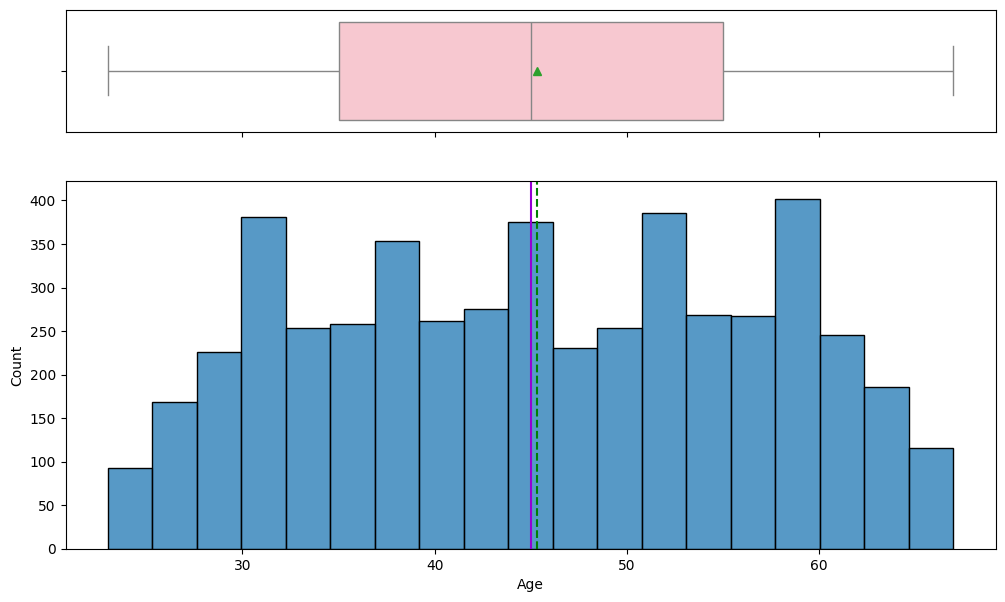

In [67]:
# Create Box Plot for Age
histogram_boxplot(loan,'Age')

* Average Age is around 45
* Several peaks observed as 30-33, 37-39, 44-46, 52-54 and 58-60
* Except for left and right ends data is fitting in uniform distribution


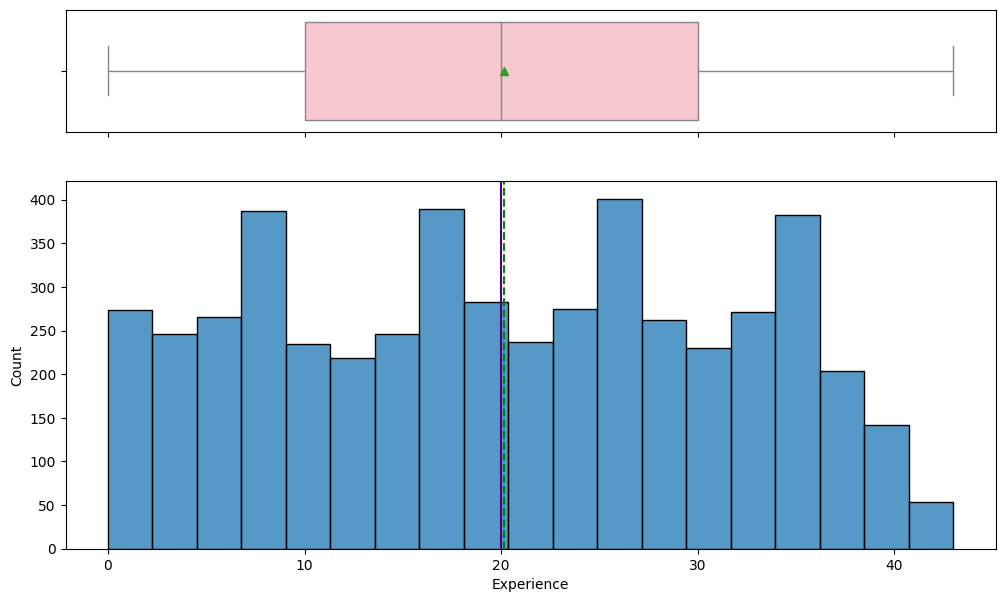

In [58]:

# Create Box Plot for Experiance
histogram_boxplot(loan,'Experience')

* Average Experiance is about 20 years
* Appears to be uniform distribution with few peaks

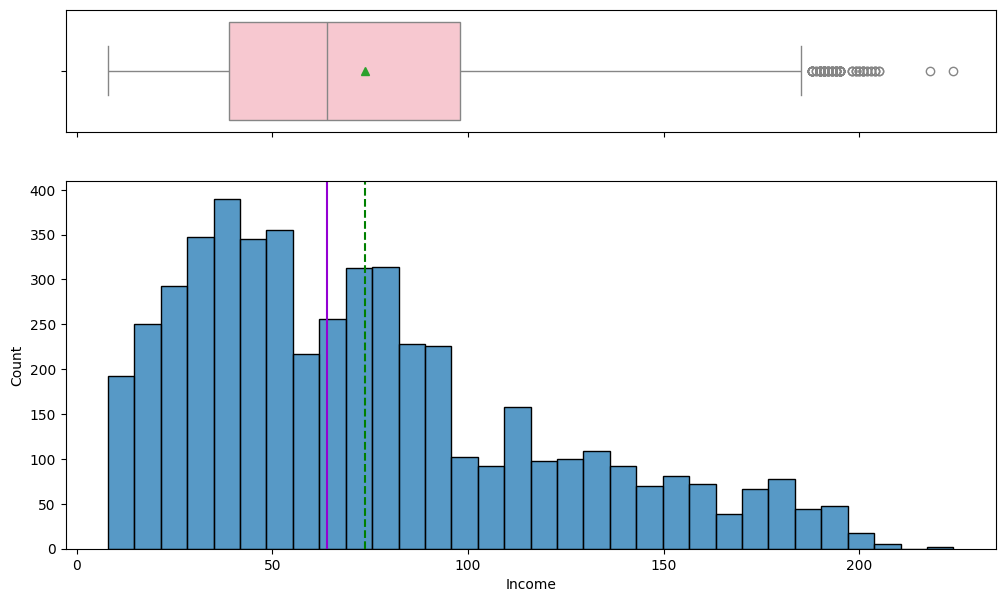

In [68]:
histogram_boxplot(loan, "Income")

* Average income is about 65K
* Median income is around 60K
* Dataset skewed to right 

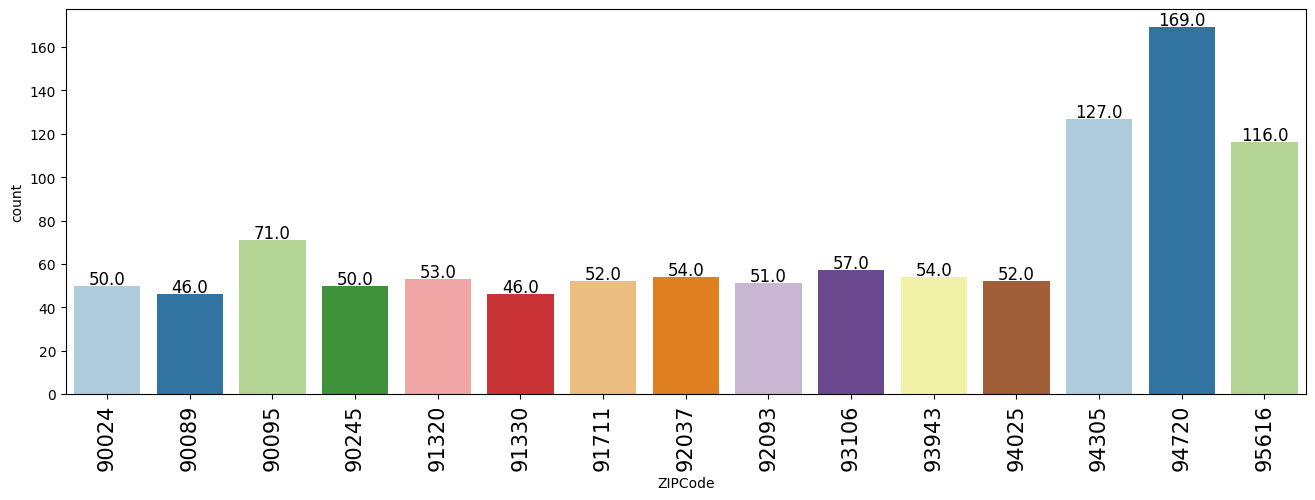

In [70]:
labeled_barplot(loan, "ZIPCode", n=15)

* Largest set of customers are from 3 zip codes 94305, 94720, 95616

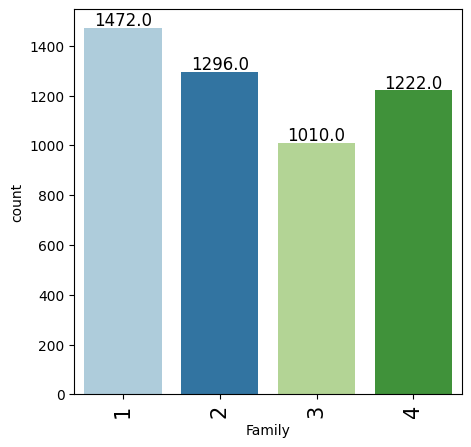

In [71]:
labeled_barplot(loan, "Family")

* Single Family is most common
* Order of Family size is 1, 2, 4, 3

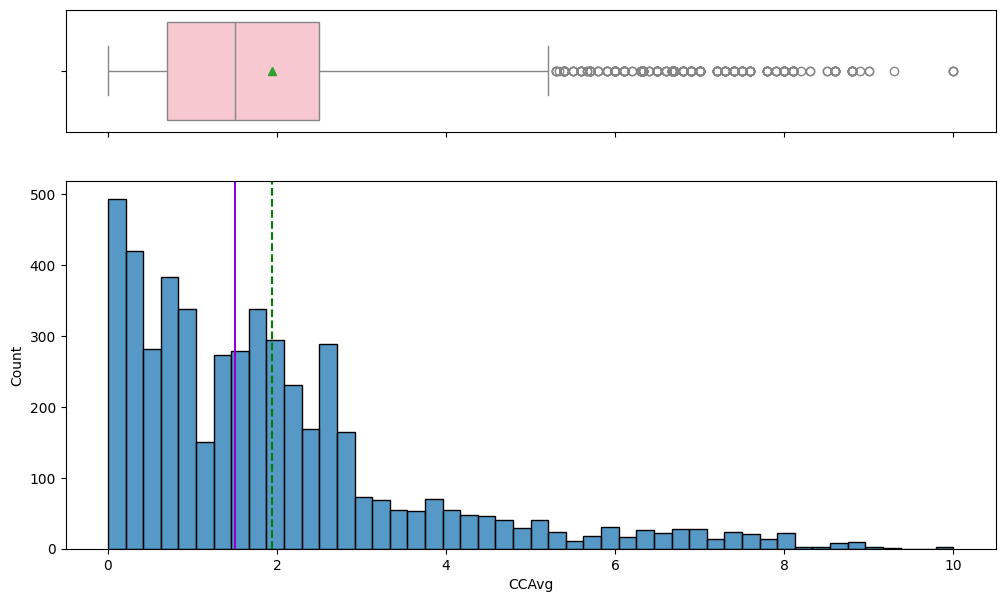

In [69]:
histogram_boxplot(loan,'CCAvg')

* Average customer spends arount $1.9K / month on Credit Card
* Dataset is right skewed with a number of outliers

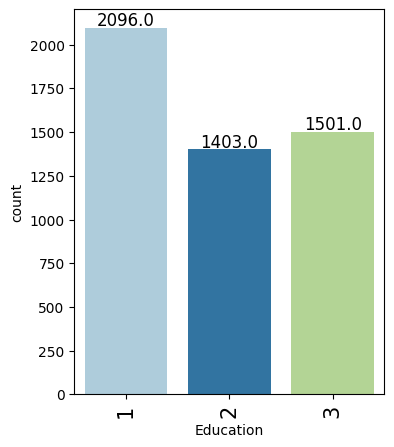

In [72]:
labeled_barplot(loan, "Education")

* Undergraduate Degree is most common
* graduate Degree is less prevalant than Professional Degree

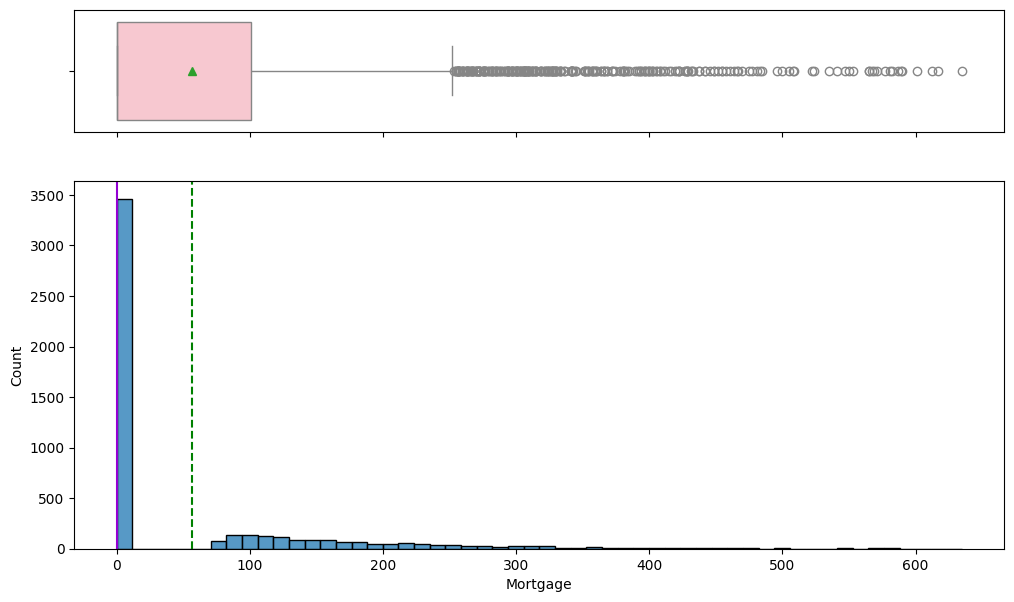

In [73]:
histogram_boxplot(loan, "Mortgage")

* Extreme Right Skewed Data Observed
* Need to seperate non-zero value mortgage to visulize better

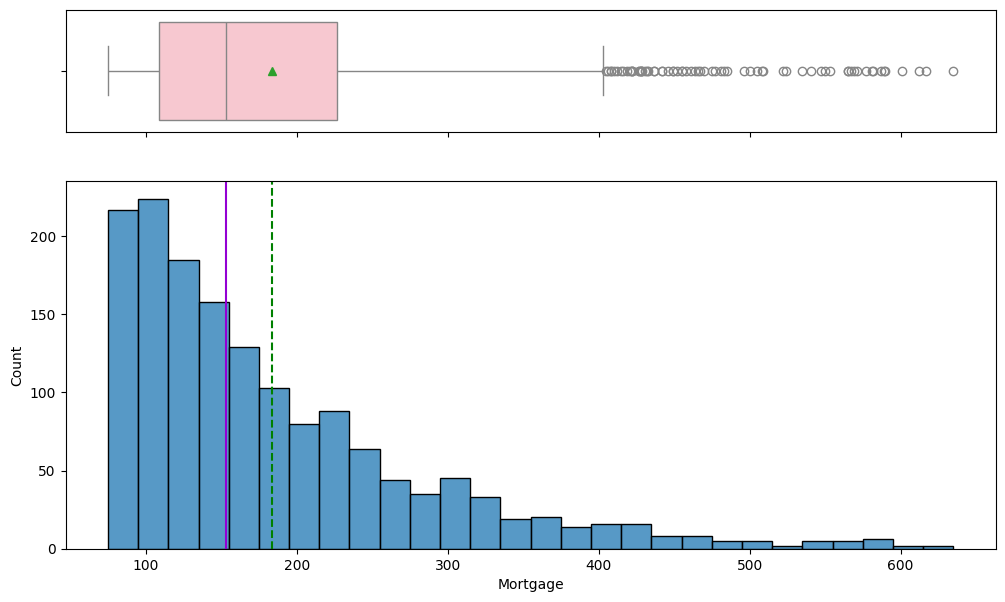

In [74]:
# Extract non zero Mortgage
df_mortgage_nonzero = loan[loan["Mortgage"] != 0].copy()
histogram_boxplot(df_mortgage_nonzero, "Mortgage")

* This excludes no mortgage customers, through right skewness still exist, but provides better picture on mortgage customers
* Lots of outliers observed

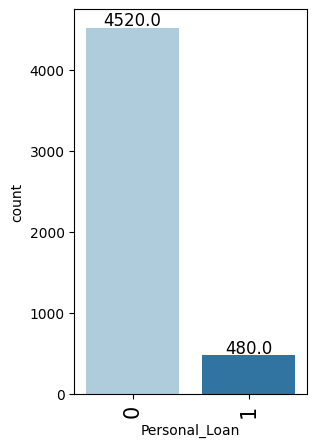

In [83]:
labeled_barplot(loan, "Personal_Loan")

* Most customers do not have personal loan with Bank

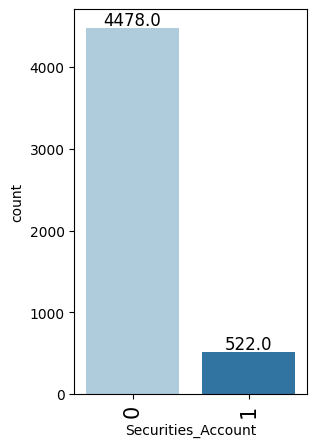

In [84]:
labeled_barplot(loan, "Securities_Account")

* Most customers do not have Securities Account

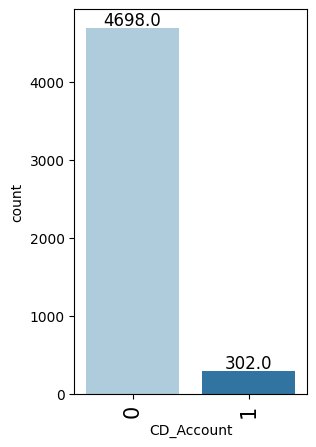

In [85]:
labeled_barplot(loan, "CD_Account")

* Most customers do not have CD Account

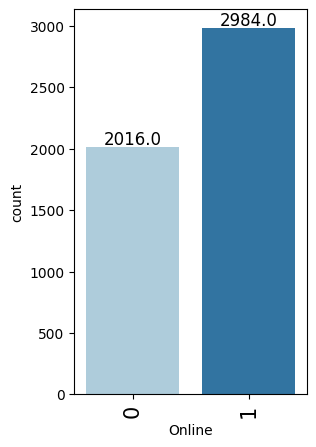

In [86]:
labeled_barplot(loan, "Online")

* Significant number of customers do not use online Banking

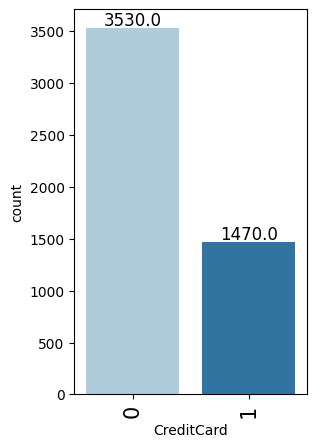

In [87]:
labeled_barplot(loan, "CreditCard")

* 70% Customers use credit card issued by Bank

<Axes: xlabel='count', ylabel='City'>

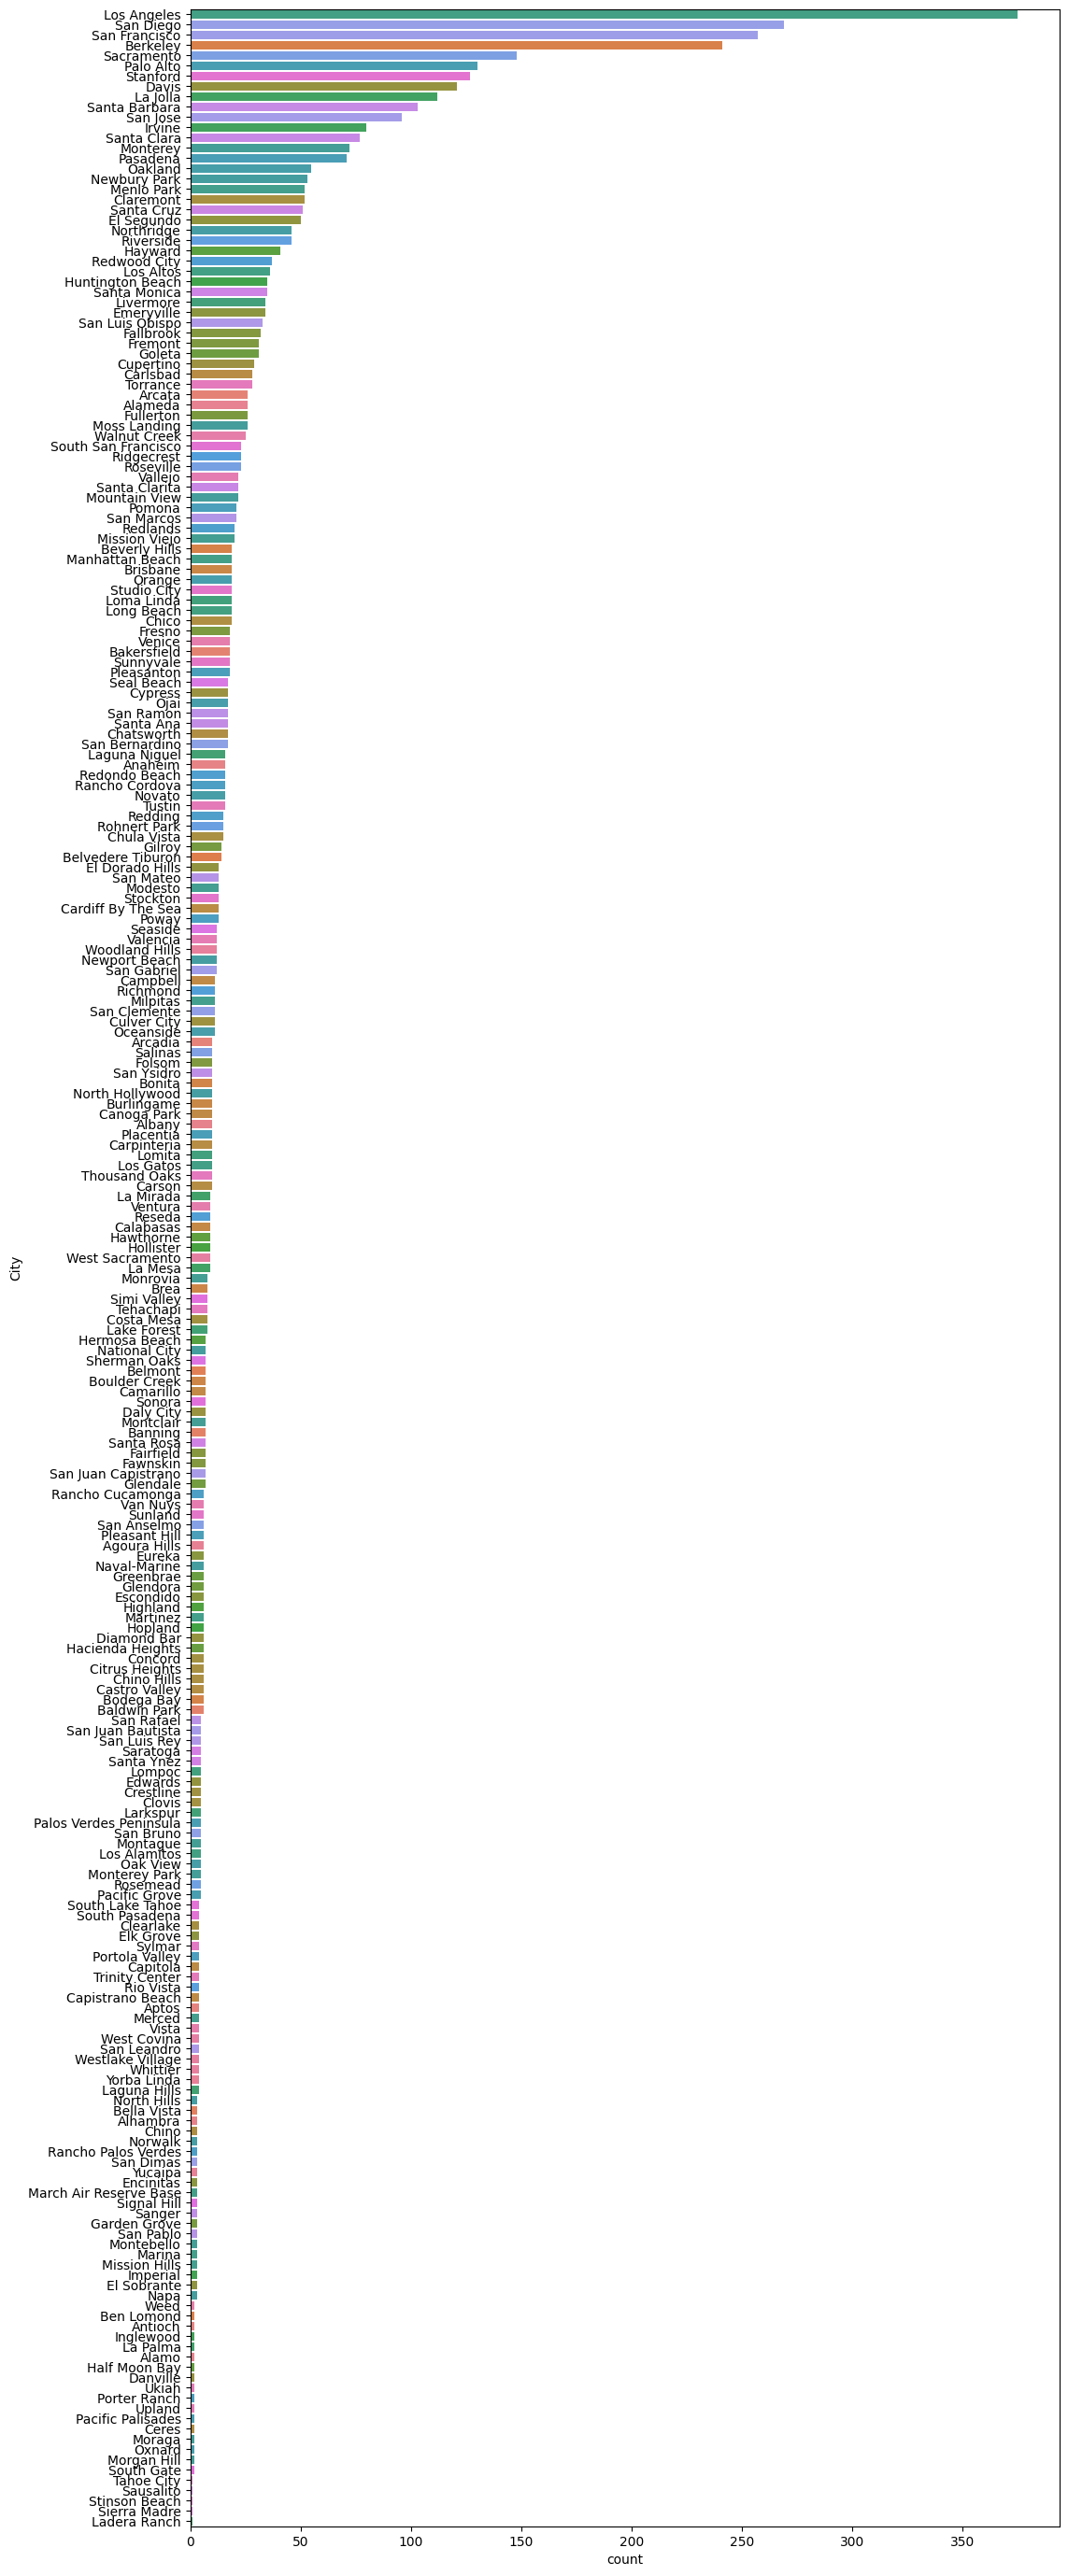

In [96]:
plt.figure(figsize=(12,35))
sns.countplot(data=loan, y='City', hue='City', order=loan['City'].value_counts().index)

* Top cities for customers are Los Angeles, San Diego, San Fransisco and so on.
* Number of cities with very few customers is huge.

### Bivariate Analysis

<Figure size 1500x1500 with 0 Axes>

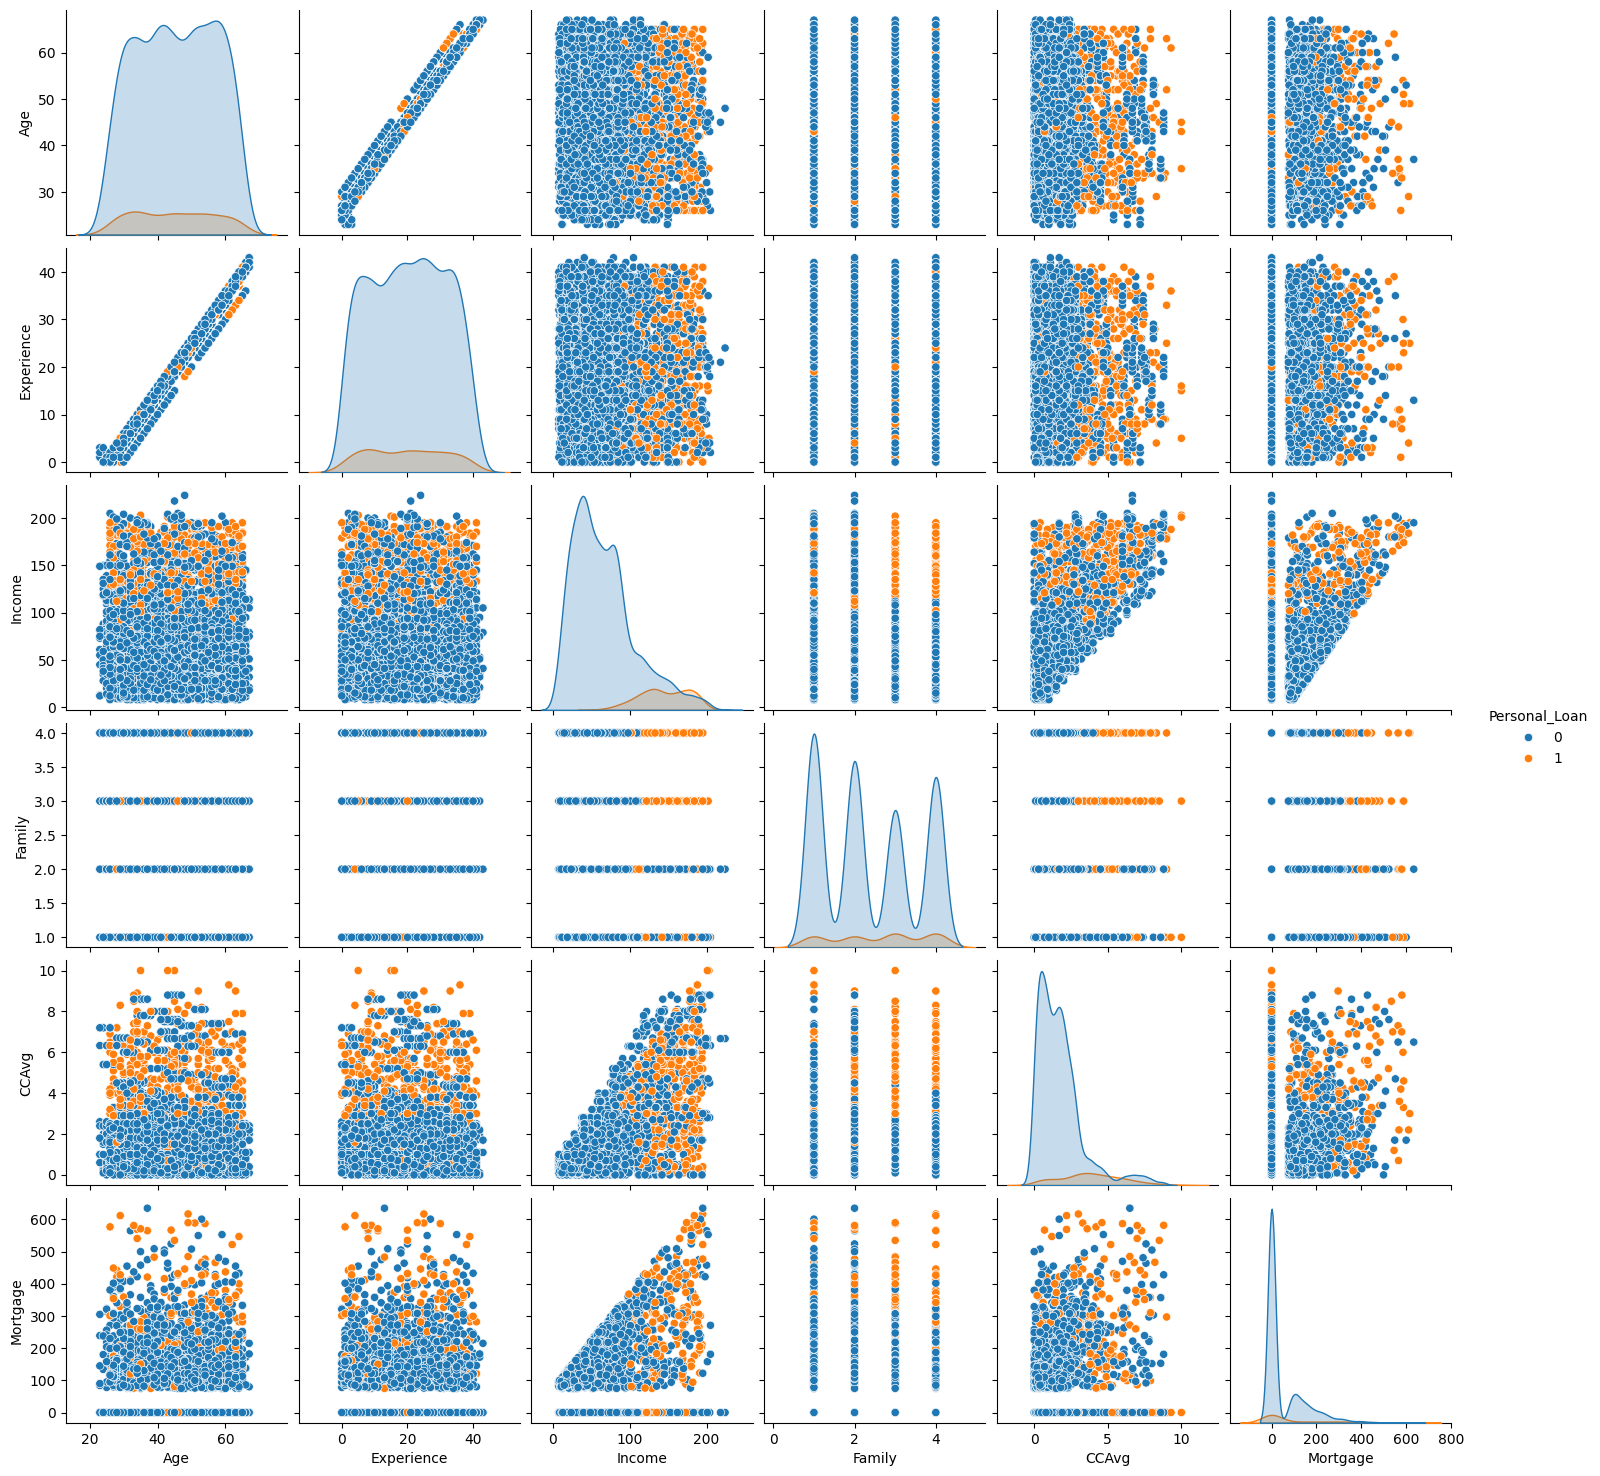

In [97]:
# Simple pair plot to see correlation between different data points
plt.figure(figsize=(15,15))
# sns.pairplot(loan, diag_kind='kde')
sns.pairplot(loan, hue="Personal_Loan")
plt.show()

* Customers with Personal Loan are represented with Orange dots and One without Personal Loan are Blue dots
* Very strong liner correlation between Age and Experiance is observed.
* Custormer with Personal Loans are having :
   * Higher Education
   * Higher Credit Card Average
   * Higher Income
   * Higher Mortgage
   * Higher Family Size

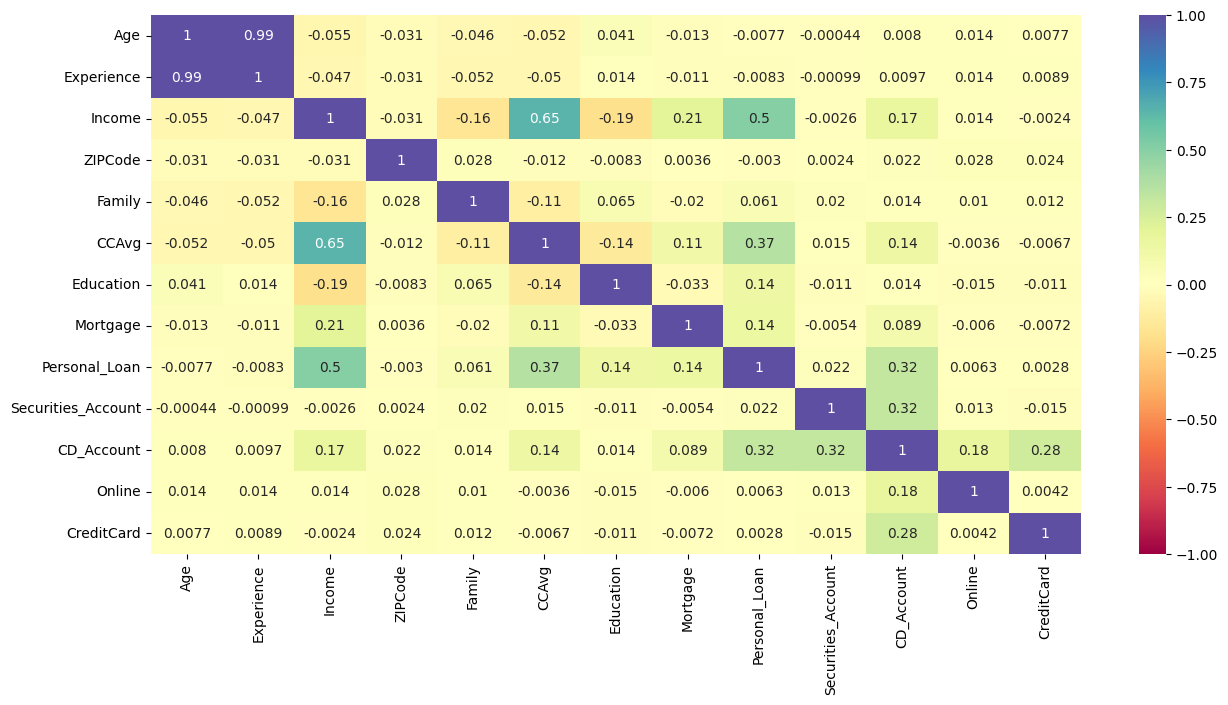

In [ ]:
# Check Correlation without City/State
plt.figure(figsize=(15, 7))
orig_loan = loan.drop(['City'], axis=1)
orig_loan.drop(['State'], axis=1, inplace=True)
sns.heatmap(orig_loan.corr(), annot=True, vmin=-1, vmax=1, cmap="Spectral")
plt.show()

* Mortgage and Income having slight positive correlation
* Age and Experiance are positively correlated
* Securities Account and CD Account has some correlation

In [113]:
# Define function to plot distributions with target
def distribution_plot_wrt_target(data, predictor, target):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()
    
def stacked_barplot(data, predictor, target, n=10):
    top_categories = data[predictor].value_counts().head(n).index
    
    # Filter the data to include only the top n categories
    filtered_data = data[data[predictor].isin(top_categories)]
    
    # Create a crosstab of the predictor and target variables
    crosstab = pd.crosstab(filtered_data[predictor], filtered_data[target], margins=False, normalize='index').sort_values(by=data[target].value_counts().index[-1], ascending=False)
    
    # Print the category counts
    print(crosstab)
    print("-" * 120)
    
    # Plot the stacked bar chart
    ax = crosstab.plot(kind="bar", stacked=True, figsize=(n + 5, 5), rot=0)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.ylabel('Proportion')
    plt.title(f'Stacked Barplot of {predictor} by {target}')
    plt.show()

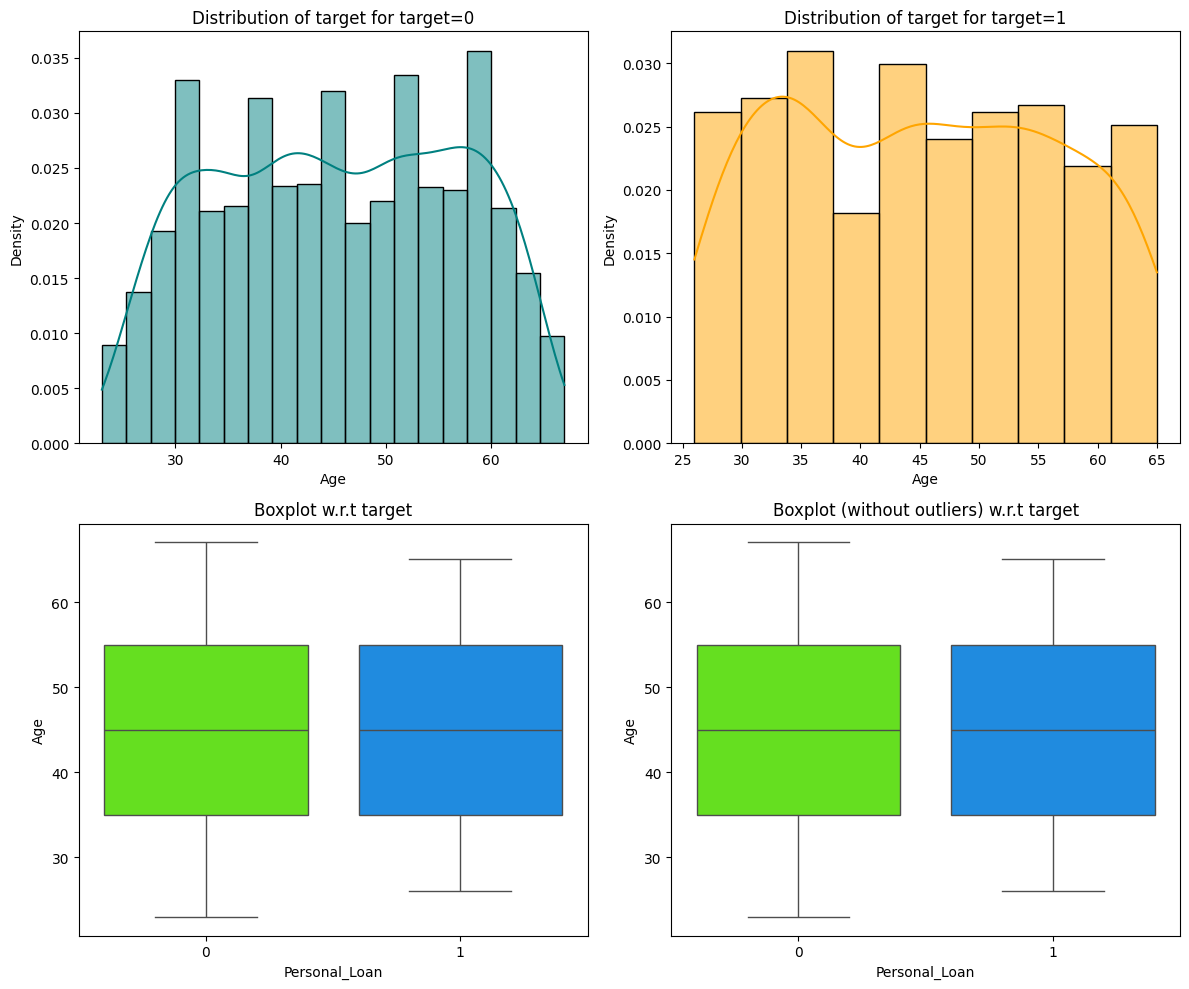

In [ ]:
# Plot Age vs Personal Loan
distribution_plot_wrt_target(loan, "Age", "Personal_Loan")

* Multiple peaks observed for both with and without personal loan* 

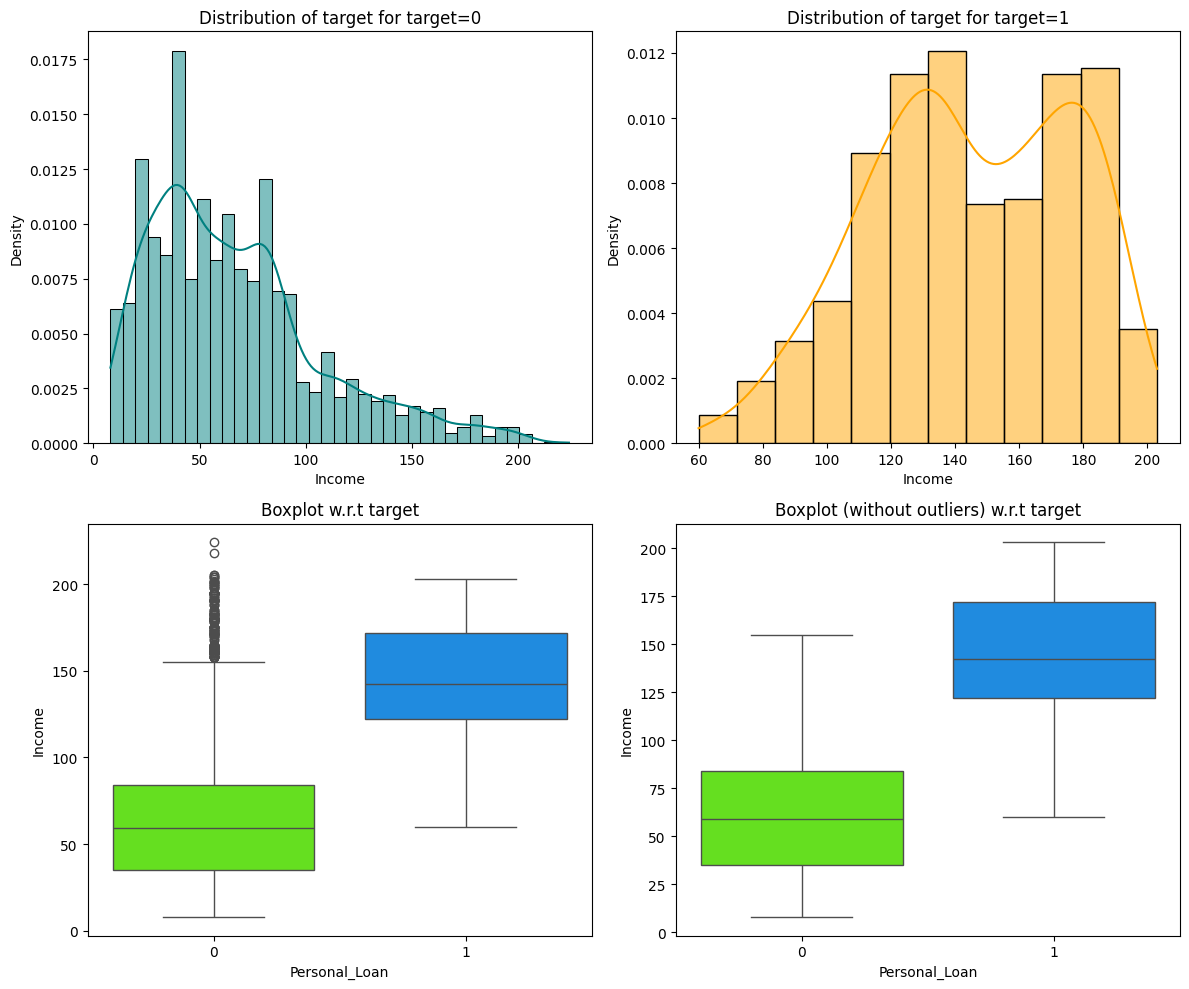

In [107]:
# Plot Income vs Personal_Loan
distribution_plot_wrt_target(loan,'Income','Personal_Loan')

* Income varies greatly between customers with and without personal loan
* Data is skewed to right for customers not having personal loan than ones having it

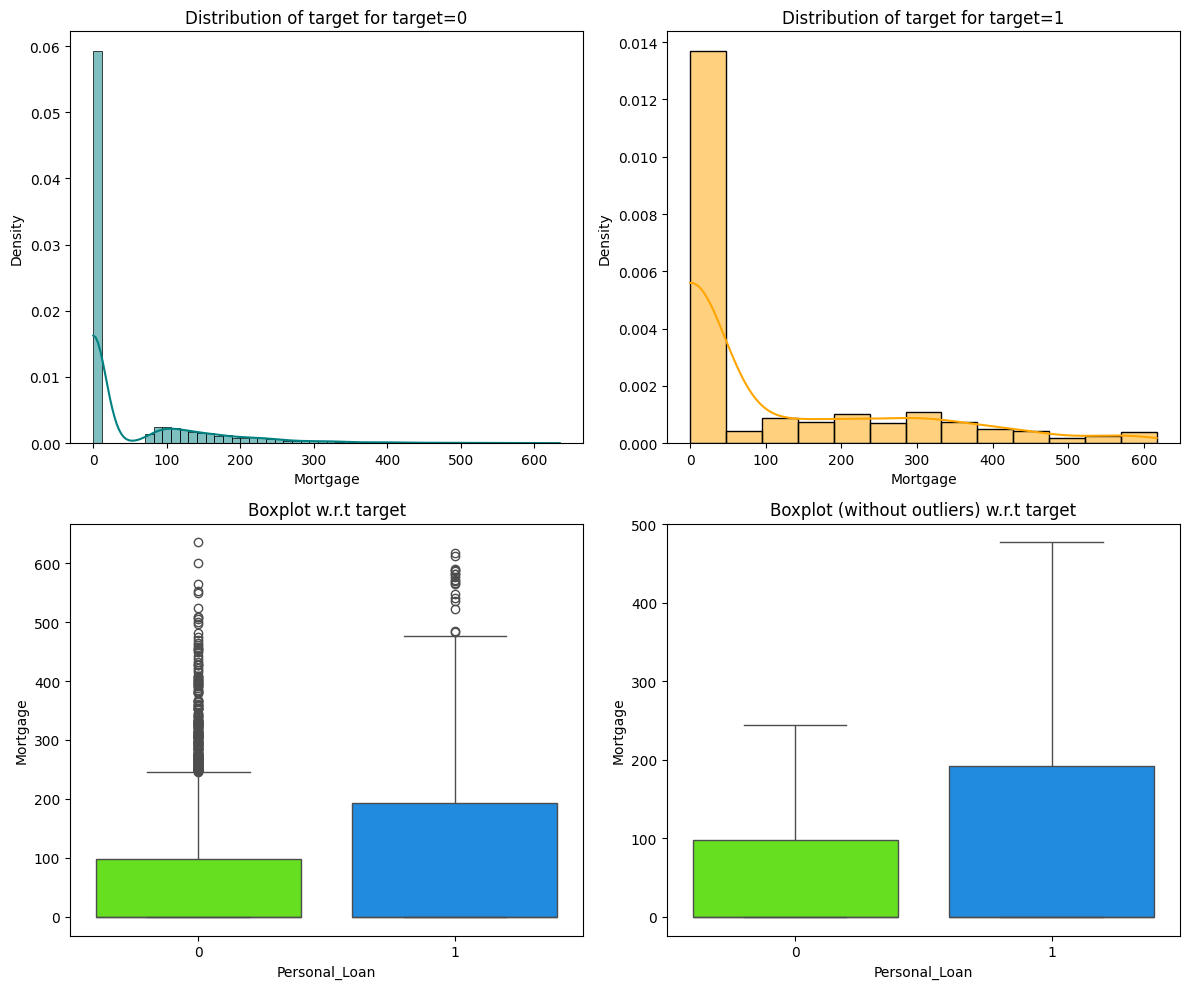

In [108]:
# Plot Mortgage vs Personal_Loan
distribution_plot_wrt_target(loan,'Mortgage','Personal_Loan')

* Data is skewed and needs to analyze with customer having mortgage

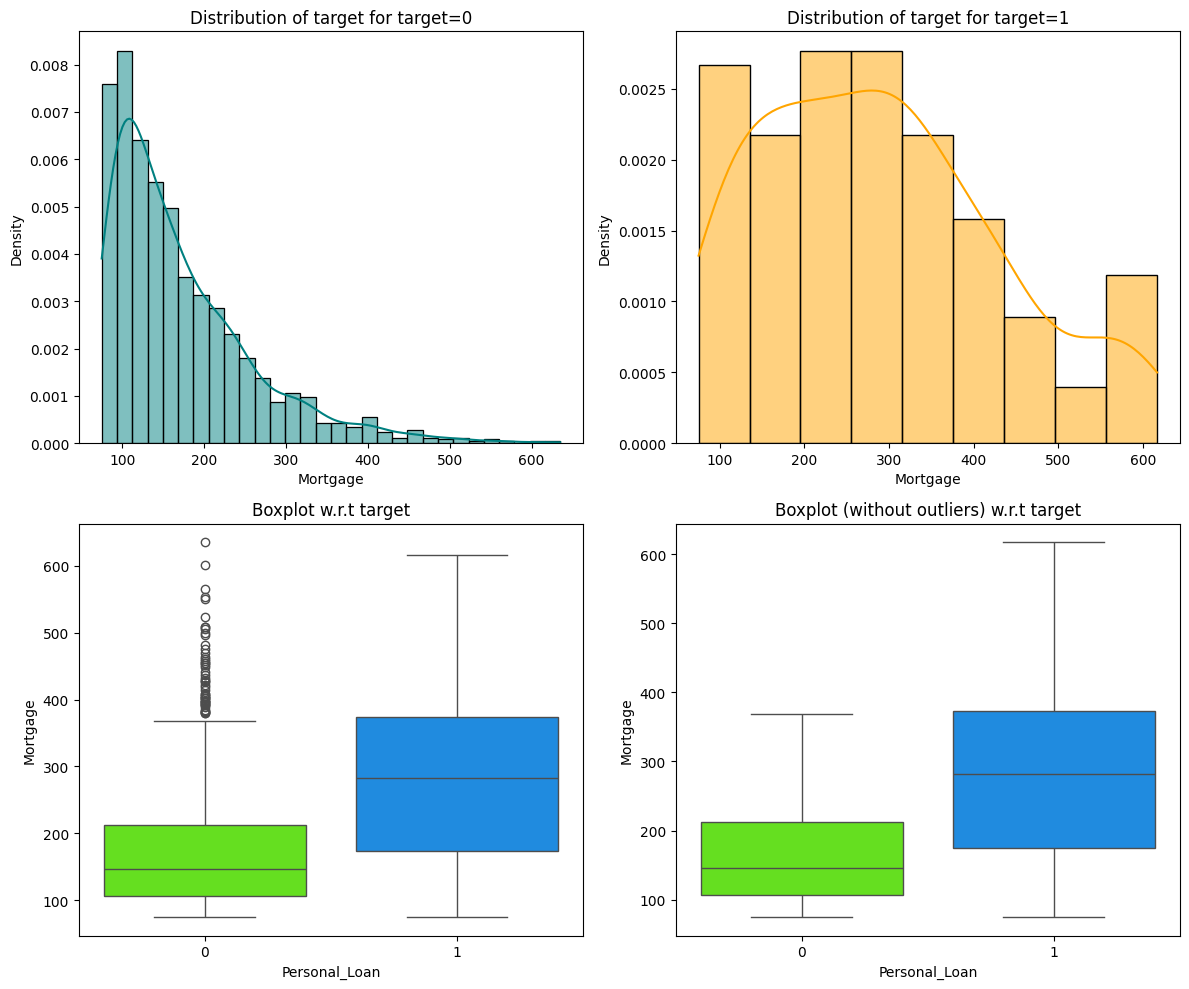

In [109]:
# Plot customers with Mortgage vs Personal Loan
distribution_plot_wrt_target(df_mortgage_nonzero,'Mortgage','Personal_Loan')

* Right skewness is observered in customer with mortgage data.
* Mean value of mortgage paid by customers not having personal loan is much less than customers having personal loan.
* With increase in mortgage value increase, chances for having personal loan is heigher

Personal_Loan         0         1
ZIPCode                          
92093          0.823529  0.176471
90089          0.826087  0.173913
90095          0.887324  0.112676
94720          0.887574  0.112426
94305          0.897638  0.102362
90245          0.900000  0.100000
92037          0.907407  0.092593
91711          0.923077  0.076923
94025          0.923077  0.076923
93943          0.925926  0.074074
93106          0.929825  0.070175
91330          0.934783  0.065217
95616          0.948276  0.051724
91320          0.962264  0.037736
90024          0.980000  0.020000
------------------------------------------------------------------------------------------------------------------------


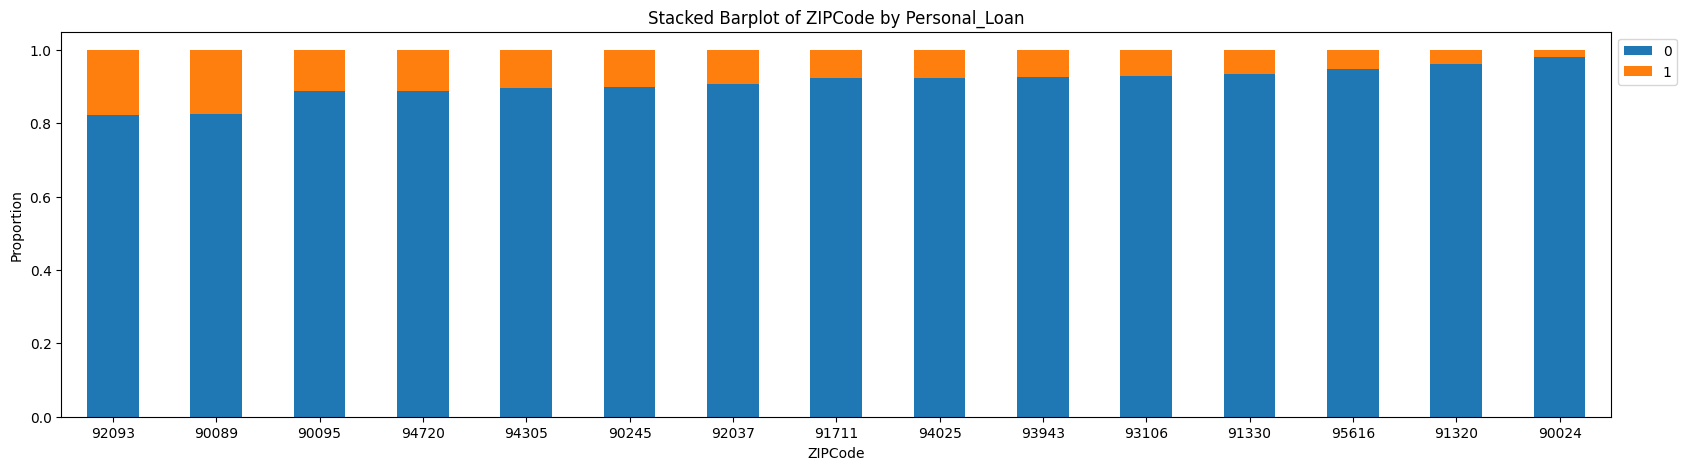

In [114]:
stacked_barplot(loan, "ZIPCode", "Personal_Loan", n=15)

* Customers from zip Codes 92093, 90089, 90095, and 94720 dominates having personal loan 

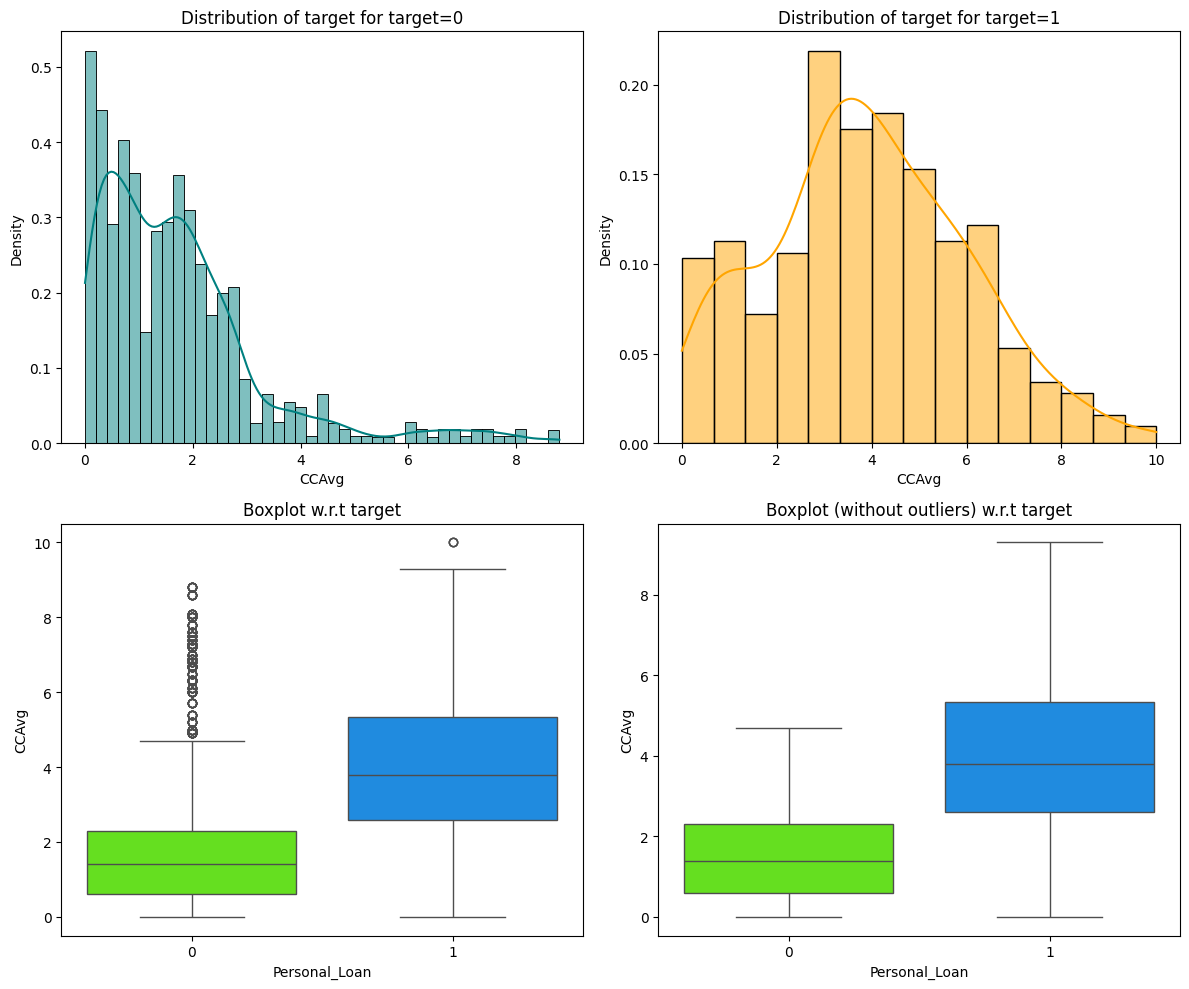

In [110]:
# CCAvg vs Personal_Loan
distribution_plot_wrt_target(loan,'CCAvg','Personal_Loan')

* Customers having personal loan also tend to have heigher credit card spending

Personal_Loan         0         1
Family                           
3              0.868317  0.131683
4              0.890344  0.109656
2              0.918210  0.081790
1              0.927310  0.072690
------------------------------------------------------------------------------------------------------------------------


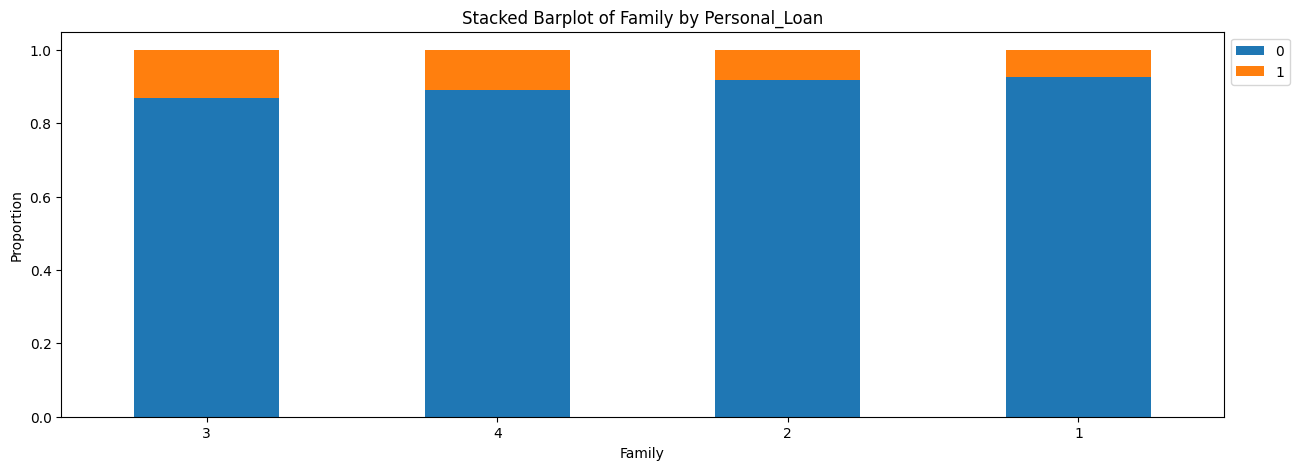

In [115]:
stacked_barplot(loan,'Family','Personal_Loan')

* As family size grows, personal loan use also increases

Personal_Loan         0         1
Education                        
3              0.863424  0.136576
2              0.870278  0.129722
1              0.955630  0.044370
------------------------------------------------------------------------------------------------------------------------


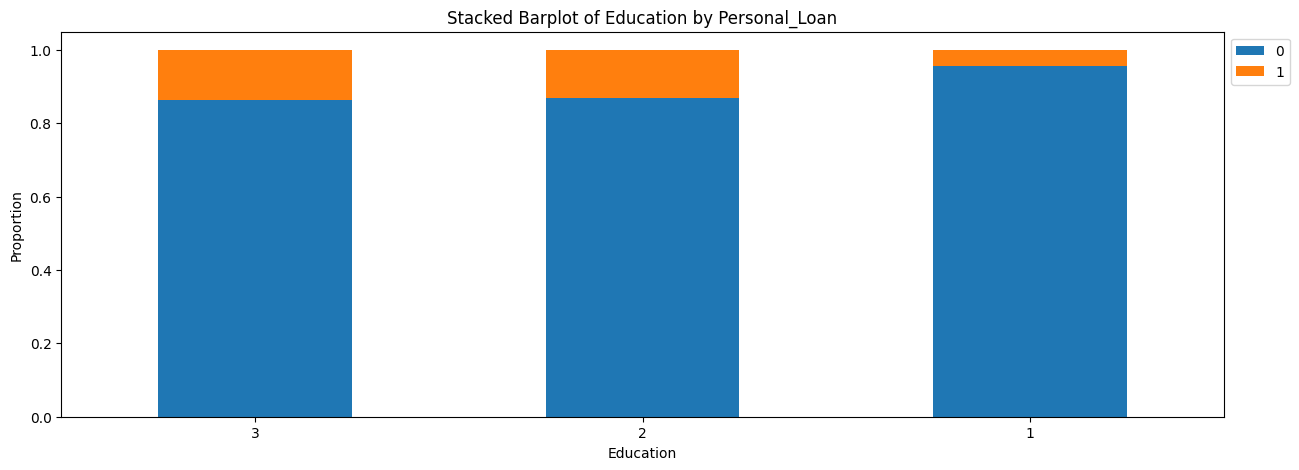

In [116]:
stacked_barplot(loan,'Education','Personal_Loan')

* Heigher Education level customers tend to have more acceptance of personal loan

Personal_Loan              0         1
Securities_Account                    
1                   0.885057  0.114943
0                   0.906208  0.093792
------------------------------------------------------------------------------------------------------------------------


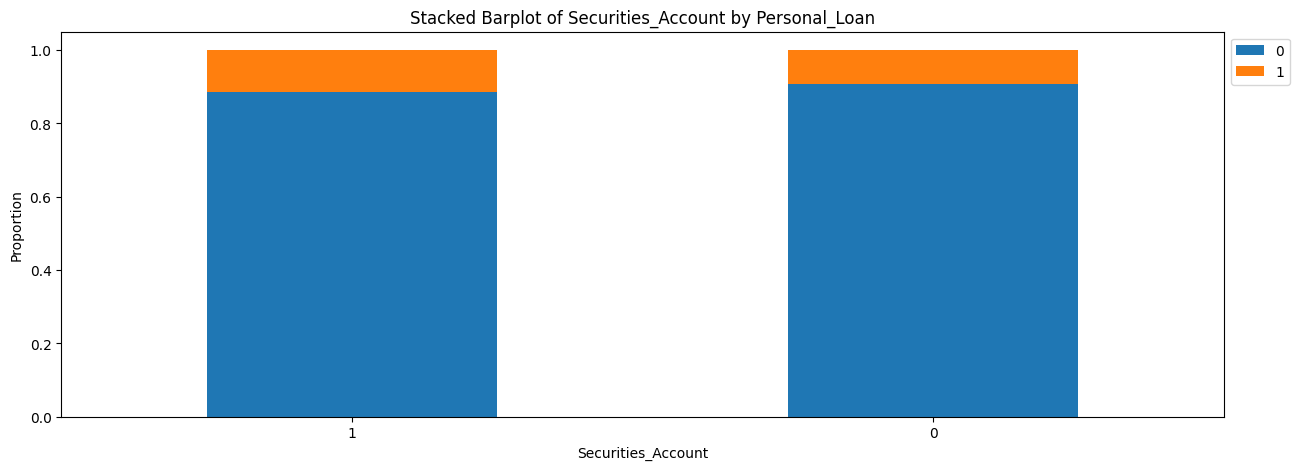

In [117]:
stacked_barplot(loan,'Securities_Account','Personal_Loan')

* Customers having Security account tend to have more acceptance of personal loan

Personal_Loan         0         1
CD_Account                       
1              0.536424  0.463576
0              0.927629  0.072371
------------------------------------------------------------------------------------------------------------------------


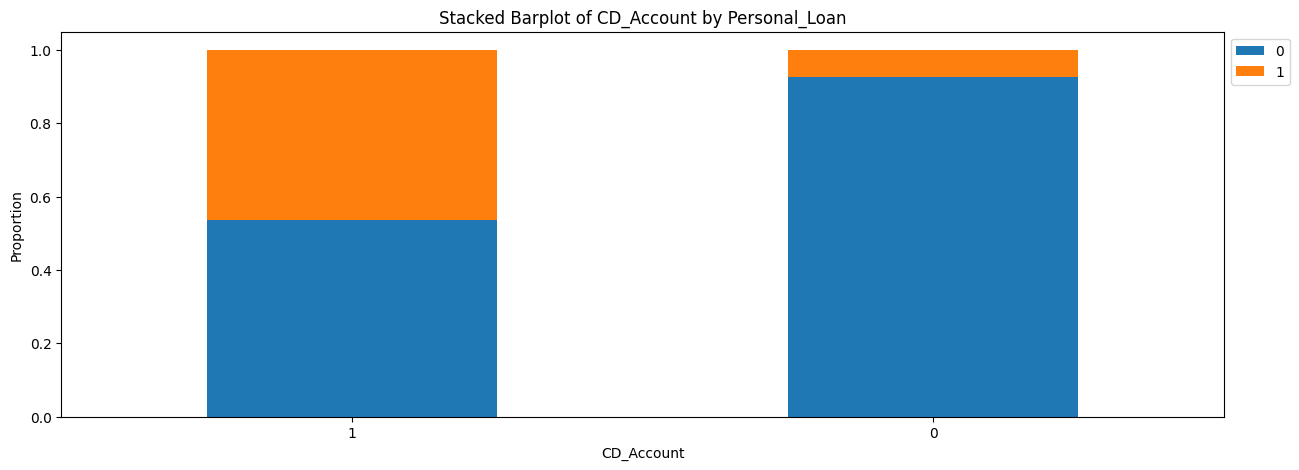

In [118]:
stacked_barplot(loan,'CD_Account','Personal_Loan')

* Customers with CD Account tend to use personal loan more

Personal_Loan        0        1
Online                         
1              0.90248  0.09752
0              0.90625  0.09375
------------------------------------------------------------------------------------------------------------------------


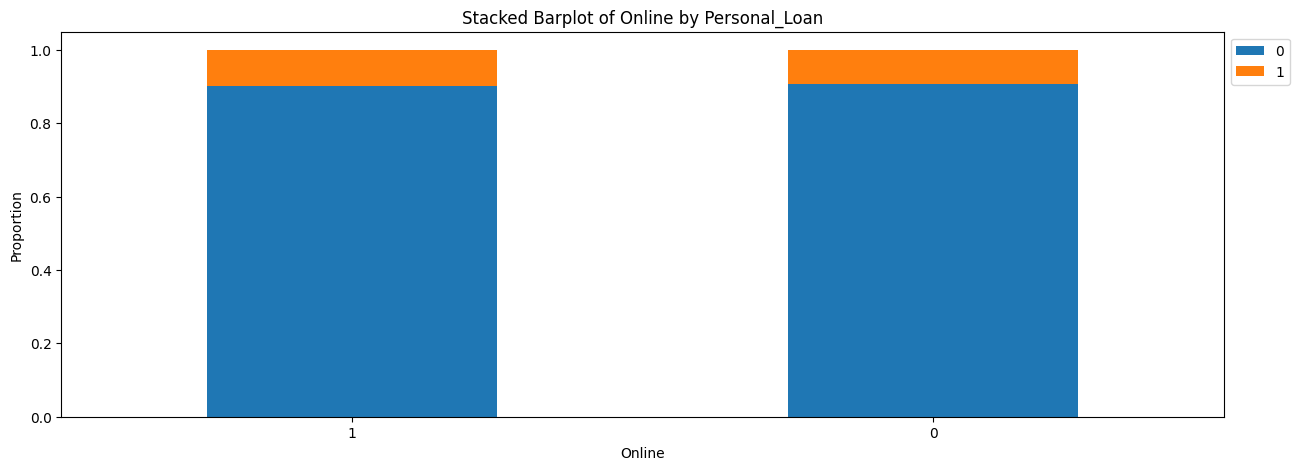

In [119]:
stacked_barplot(loan,'Online','Personal_Loan')

* Online users have slight edge in accepting personal loan

Personal_Loan         0         1
CreditCard                       
1              0.902721  0.097279
0              0.904533  0.095467
------------------------------------------------------------------------------------------------------------------------


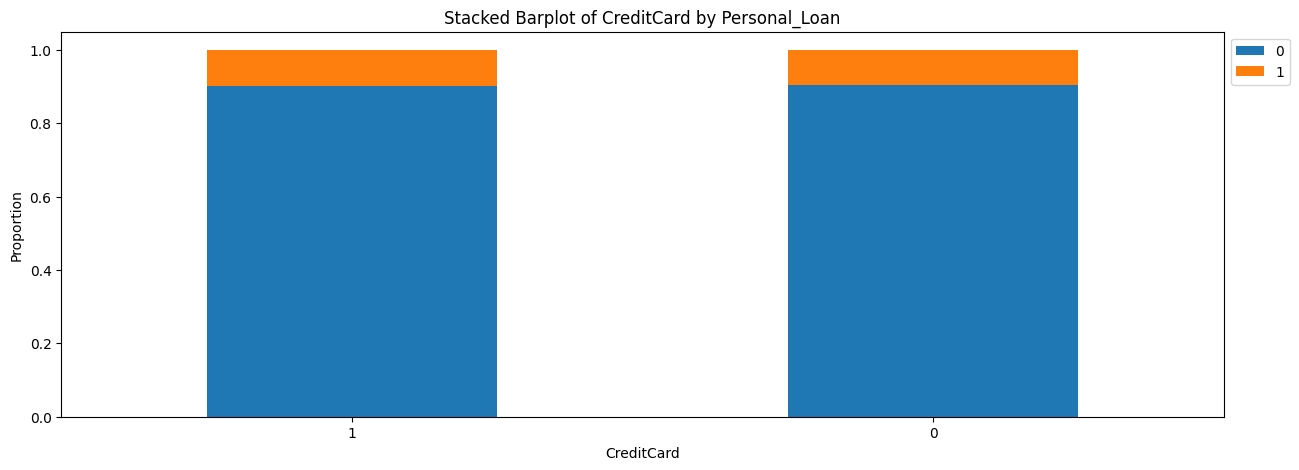

In [120]:
stacked_barplot(loan,'CreditCard','Personal_Loan')

* Customers with or without credit card account tends to have similar acceptance of personal loan

Personal_Loan         0         1
City                             
La Jolla       0.866071  0.133929
Palo Alto      0.876923  0.123077
Berkeley       0.887967  0.112033
Stanford       0.897638  0.102362
Los Angeles    0.898667  0.101333
Sacramento     0.912162  0.087838
San Diego      0.921933  0.078067
Santa Barbara  0.922330  0.077670
San Francisco  0.926070  0.073930
Davis          0.950413  0.049587
------------------------------------------------------------------------------------------------------------------------


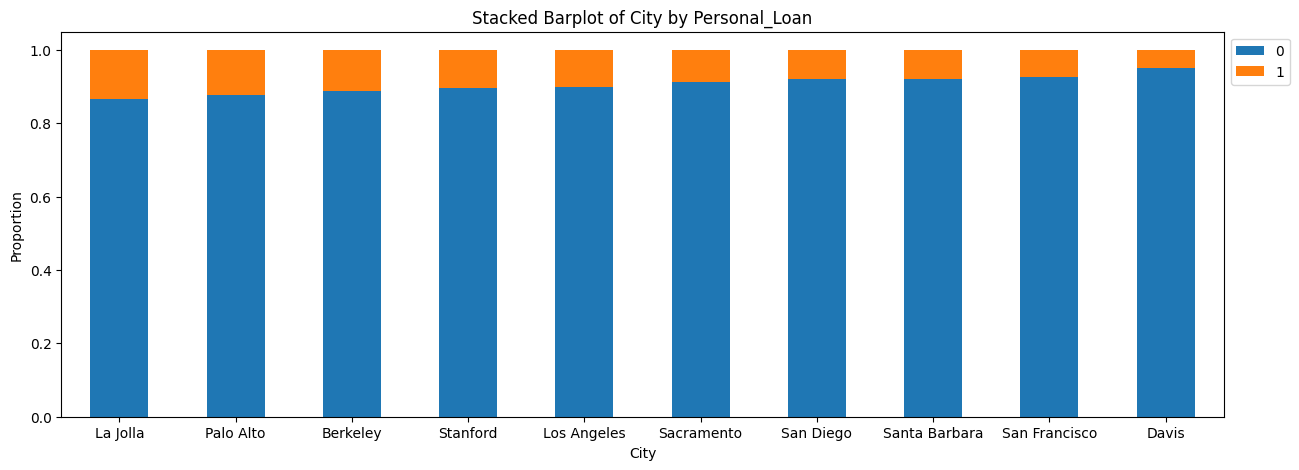

In [122]:
stacked_barplot(loan,'City','Personal_Loan')

* Top 10 cities from above list shows most potential for personal loan

Personal_Loan         0         1
State                            
CA             0.903885  0.096115
AP             1.000000  0.000000
------------------------------------------------------------------------------------------------------------------------


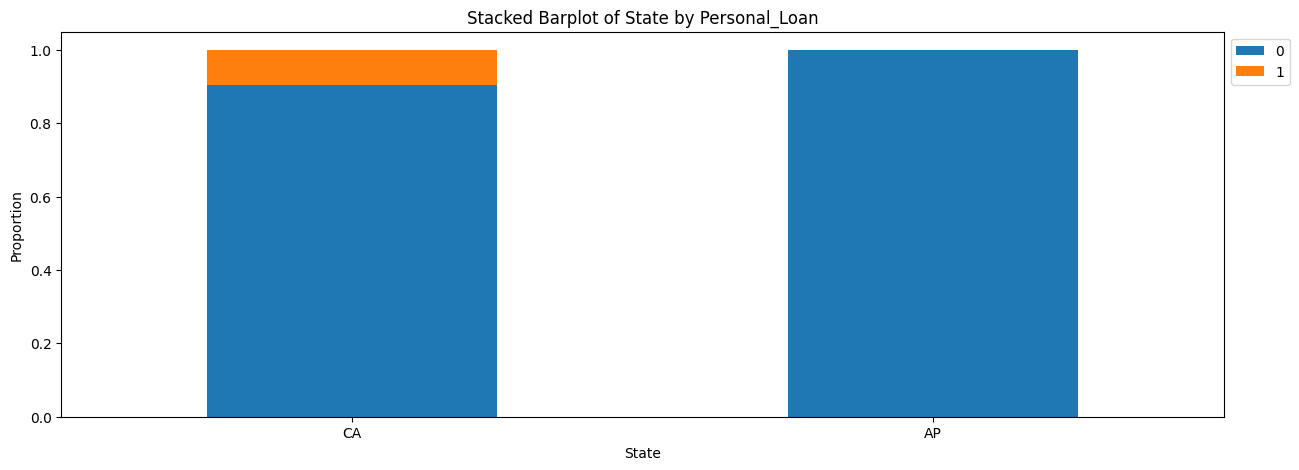

In [128]:
stacked_barplot(loan,'State','Personal_Loan')

* Not much diversity is observed in terms of number of states, though data suggest that customers from California are more willing to accept personal loan

### Key Insights based on EDA

In [129]:
loan.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,5000.0,NaN,NaN,NaN,45.3384,11.463166,23.0,35.0,45.0,55.0,67.0
Experience,5000.0,NaN,NaN,NaN,20.1346,11.415189,0.0,10.0,20.0,30.0,43.0
Income,5000.0,NaN,NaN,NaN,73.7742,46.033729,8.0,39.0,64.0,98.0,224.0
ZIPCode,5000.0,467.0,94720.0,169.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Family,5000.0,NaN,NaN,NaN,2.3964,1.147663,1.0,1.0,2.0,3.0,4.0
CCAvg,5000.0,NaN,NaN,NaN,1.937938,1.747659,0.0,0.7,1.5,2.5,10.0
Education,5000.0,3.0,1.0,2096.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mortgage,5000.0,NaN,NaN,NaN,56.4988,101.713802,0.0,0.0,0.0,101.0,635.0
Personal_Loan,5000.0,2.0,0.0,4520.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Securities_Account,5000.0,2.0,0.0,4478.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Key Findings from Univariate Analysis:

* The age range of customers spans from a minimum of 23 years to a maximum of 67 years, with an average age of 45 years. The data seems to somewhat align with a uniform distribution.
* The years of experience range from 0 to 43, with an average of approximately 20 years.
* The minimum CCAvg is USD 0k (possibly indicating customers without credit cards), while the maximum is USD 1.9K, and the average stands at USD 10K.
* Around 69% of customers are not paying a mortgage, while the remaining 31% have mortgage amounts ranging from approximately USD 99K to 635K, with an average mortgage value between USD 180K and 200K.
* The leading cities with the highest number of customers are Los Angeles, followed by San Diego, San Francisco, Berkeley, and Sacramento.
* California (CA) emerges as the state with the highest concentration of customers.
* Family sizes predominantly consist of 1 member (29.4%), followed by 2 members (25.9%), 4 members (24.4%), and 3 members (20.2%).
* Customer education levels are as follows:
    * 41.9% have an undergraduate degree.
    * 28.1% hold a graduate degree.
    * 30.0% possess an advanced or professional degree.
* A significant 94% of customers do not have a CD_Account, while only 6% hold a CD_Account.
* 40.3% of customers do not use online banking services, leaving 59.7% who do.
* 70.6% of customers do not possess a credit card, while 29.4% do.
* Regarding the target variable, Personal_Loan, 90.4% of customers did not accept a loan, while 9.6% did.

### Key Insights from Multivariate Analysis:

* Correlation between variables:

    * A strong correlation (0.98) is observed between Age and Experience.
    * The relationship between Income and CCAvg is relatively weak (0.65).
    * The correlation between other variable pairs is minimal and not significant.

* Impact of variables on the target (Personal_Loan):

    * Income: Higher income increases the likelihood of loan acceptance.
    * Family Size: Larger family sizes correlate with higher loan acceptance rates.
    * CCAvg: Increased monthly spending leads to a higher probability of accepting a personal loan.
    * Education: Customers with higher education levels are more likely to accept a personal loan.
    * Mortgage: Higher mortgage amounts are linked to greater loan acceptance.
    * City: Santa Clara has the highest proportion of customers accepting loans, followed by Pasadena and Irvine.
    * State: Customers from California are more inclined to accept personal loans.
    * Securities Account: Customers with a securities account show a greater likelihood of accepting a loan.
    * CD Account: Having a CD Account increases the chances of accepting a personal loan.
    * Online Banking: No significant effect observed on loan acceptance.
    * Age, Experience, Credit Card: These variables show no notable influence on the target variable.

* Expected Target Dependencies:

    * Low Importance: Age, Experience, Credit Card, and Online Banking have minimal impact on loan acceptance.
    * Medium to High Importance: Income, Family Size, CCAvg, Education, Mortgage, Securities Account, and CD Account are expected to have a significant influence on loan acceptance.

## Model Building

### Data Preparation for modelling

Data Pre-proccesing actions take before :

1. Dropped unwanted ID column
2. Negative values in Experience column replaced by positive one, assuming its typo, median could have been used to replace -ve value but converting -ve to positive is natural fit.
3. ZIP Code Column was split into City and state then dropped

1. Creating the dummy variables

In [164]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
loan['State'] = le.fit_transform(loan['State']) 
# Create dummy variables
df_model = pd.get_dummies(
    loan,
    columns=[
        "ZIPCode",
        "Education",
        "City",
        "State",
    ],
    drop_first=True,
)

df_model.head()

,Age,Experience,Income,Family,CCAvg,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,ZIPCode_90007,ZIPCode_90009,ZIPCode_90011,ZIPCode_90016,ZIPCode_90018,ZIPCode_90019,ZIPCode_90024,ZIPCode_90025,ZIPCode_90027,ZIPCode_90028,ZIPCode_90029,ZIPCode_90032,ZIPCode_90033,ZIPCode_90034,ZIPCode_90035,ZIPCode_90036,ZIPCode_90037,ZIPCode_90041,ZIPCode_90044,ZIPCode_90045,ZIPCode_90048,ZIPCode_90049,ZIPCode_90057,ZIPCode_90058,ZIPCode_90059,ZIPCode_90064,ZIPCode_90065,ZIPCode_90066,ZIPCode_90068,ZIPCode_90071,ZIPCode_90073,ZIPCode_90086,ZIPCode_90089,ZIPCode_90095,ZIPCode_90210,ZIPCode_90212,ZIPCode_90230,ZIPCode_90232,ZIPCode_90245,ZIPCode_90250,ZIPCode_90254,ZIPCode_90266,ZIPCode_90272,ZIPCode_90274,ZIPCode_90275,ZIPCode_90277,ZIPCode_90280,ZIPCode_90291,ZIPCode_90304,ZIPCode_90401,ZIPCode_90404,ZIPCode_90405,ZIPCode_90502,ZIPCode_90503,ZIPCode_90504,ZIPCode_90505,ZIPCode_90509,ZIPCode_90601,ZIPCode_90623,ZIPCode_90630,ZIPCode_90638,ZIPCode_90639,ZIPCode_90640,ZIPCode_90650,ZIPCode_90717,ZIPCode_90720,ZIPCode_90740,ZIPCode_90745,ZIPCode_90747,ZIPCode_90755,ZIPCode_90813,ZIPCode_90840,ZIPCode_91006,ZIPCode_91007,ZIPCode_91016,ZIPCode_91024,ZIPCode_91030,ZIPCode_91040,ZIPCode_91101,ZIPCode_91103,ZIPCode_91105,ZIPCode_91107,ZIPCode_91109,ZIPCode_91116,ZIPCode_91125,ZIPCode_91129,ZIPCode_91203,ZIPCode_91207,ZIPCode_91301,ZIPCode_91302,ZIPCode_91304,ZIPCode_91311,ZIPCode_91320,ZIPCode_91326,ZIPCode_91330,ZIPCode_91335,ZIPCode_91342,ZIPCode_91343,ZIPCode_91345,ZIPCode_91355,ZIPCode_91360,ZIPCode_91361,ZIPCode_91365,ZIPCode_91367,ZIPCode_91380,ZIPCode_91401,ZIPCode_91423,ZIPCode_91604,ZIPCode_91605,ZIPCode_91614,ZIPCode_91706,ZIPCode_91709,ZIPCode_91710,ZIPCode_91711,ZIPCode_91730,ZIPCode_91741,ZIPCode_91745,ZIPCode_91754,ZIPCode_91763,ZIPCode_91765,ZIPCode_91768,ZIPCode_91770,ZIPCode_91773,ZIPCode_91775,ZIPCode_91784,ZIPCode_91791,ZIPCode_91801,ZIPCode_91902,ZIPCode_91910,ZIPCode_91911,ZIPCode_91941,ZIPCode_91942,ZIPCode_91950,ZIPCode_92007,ZIPCode_92008,ZIPCode_92009,ZIPCode_92024,ZIPCode_92028,ZIPCode_92029,ZIPCode_92037,ZIPCode_92038,ZIPCode_92054,ZIPCode_92056,ZIPCode_92064,ZIPCode_92068,ZIPCode_92069,ZIPCode_92084,ZIPCode_92093,ZIPCode_92096,ZIPCode_92101,ZIPCode_92103,ZIPCode_92104,ZIPCode_92106,ZIPCode_92109,ZIPCode_92110,ZIPCode_92115,ZIPCode_92116,ZIPCode_92120,ZIPCode_92121,ZIPCode_92122,ZIPCode_92123,ZIPCode_92124,ZIPCode_92126,ZIPCode_92129,ZIPCode_92130,ZIPCode_92131,ZIPCode_92152,ZIPCode_92154,ZIPCode_92161,ZIPCode_92173,ZIPCode_92177,ZIPCode_92182,ZIPCode_92192,ZIPCode_92220,ZIPCode_92251,ZIPCode_92325,ZIPCode_92333,ZIPCode_92346,ZIPCode_92350,ZIPCode_92354,ZIPCode_92373,ZIPCode_92374,ZIPCode_92399,ZIPCode_92407,ZIPCode_92507,ZIPCode_92518,ZIPCode_92521,ZIPCode_92606,ZIPCode_92612,ZIPCode_92614,ZIPCode_92624,ZIPCode_92626,ZIPCode_92630,ZIPCode_92634,ZIPCode_92646,ZIPCode_92647,ZIPCode_92648,ZIPCode_92653,ZIPCode_92660,ZIPCode_92661,ZIPCode_92672,ZIPCode_92673,ZIPCode_92675,ZIPCode_92677,ZIPCode_92691,ZIPCode_92692,ZIPCode_92694,ZIPCode_92697,ZIPCode_92703,ZIPCode_92704,ZIPCode_92705,ZIPCode_92709,ZIPCode_92717,ZIPCode_92735,ZIPCode_92780,ZIPCode_92806,ZIPCode_92807,ZIPCode_92821,ZIPCode_92831,ZIPCode_92833,ZIPCode_92834,ZIPCode_92835,ZIPCode_92843,ZIPCode_92866,ZIPCode_92867,ZIPCode_92868,ZIPCode_92870,ZIPCode_92886,ZIPCode_93003,ZIPCode_93009,ZIPCode_93010,ZIPCode_93014,ZIPCode_93022,ZIPCode_93023,ZIPCode_93033,ZIPCode_93063,ZIPCode_93065,ZIPCode_93077,ZIPCode_93101,ZIPCode_93105,ZIPCode_93106,ZIPCode_93107,ZIPCode_93108,ZIPCode_93109,ZIPCode_93111,ZIPCode_93117,ZIPCode_93118,ZIPCode_93302,ZIPCode_93305,ZIPCode_93311,ZIPCode_93401,ZIPCode_93403,ZIPCode_93407,ZIPCode_93437,ZIPCode_93460,ZIPCode_93524,ZIPCode_93555,ZIPCode_93561,ZIPCode_93611,ZIPCode_93657,ZIPCode_93711,ZIPCode_93720,ZIPCode_93727,ZIPCode_93907,ZIPCode_93933,ZIPCode_93940,ZIPCode_93943,ZIPCode_93950,ZIPCode_93955,ZIPCode_94002,ZIPCode_94005,ZIPCode_94010,ZIPCode_94015,ZIPCode_94019,ZIPCode_94022,ZIPCode_94024,ZIPCode_94025,ZIPCode_94028,Z

In [165]:
# get shape of the dataset
df_model.shape

(5000, 724)

2. Splitting the data

In [166]:
# Define Variables
x = loan.drop(["Personal_Loan"], axis=1)
y = loan["Personal_Loan"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

In [167]:
# Show  train and test dataset shape
print(f'x_train shape:{x_train.shape}')
print(f'x_test shape:{x_test.shape}')

x_train shape:(3500, 14)
x_test shape:(1500, 14)


In [169]:
# % of target variable classes in the train and test sets
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Percentage of classes in training set:
Personal_Loan
0    0.905429
1    0.094571
Name: proportion, dtype: float64
Percentage of classes in test set:
Personal_Loan
0    0.900667
1    0.099333
Name: proportion, dtype: float64


### Model Evaluation Criterion

A model's incorrect predictions can lead to two types of errors:

1. False Positive: Predicting a customer would take a loan, but they actually wouldn’t.
    * This results in wasted resources.
2. False Negative: Predicting a customer would not take a loan, but they actually would.
    * This leads to missed opportunities.

#### Which error should we prioritize minimizing?
    * A False Negative is more critical as it implies a missed opportunity to provide a loan to a willing customer.

#### How to reduce False Negatives?
    * To mitigate this, we aim to maximize recall, as higher recall reduces the chances of False Negatives.

### Next Steps:
1. Metric Functions:
    * Develop a get_recall_score function to evaluate model performance.
2. Visualization:
    * Create a make_confusion_matrix function to visualize confusion matrices and analyze the results of the models.

In [157]:
# Define Function to calculate recall score
def get_recall_score(model, predictors, target):
    """
    model: classifier
    predictors: independent variables
    target: dependent variable
    
    """
    prediction = model.predict(predictors)
    return recall_score(target, prediction)

# Define Function for confusion matrix
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Model Building

1. **Logistic Regression**  
Let's begin by defining functions to aid in evaluating the performance of the Logistic Regression model:  

- **`confusion_matrix_sklearn_with_threshold`**: Generates the confusion matrix for the classification model.  
- **`model_performance_classification_sklearn_with_threshold`**: Calculates various evaluation metrics.  
- **`plot_prec_recall_vs_thresh`**: Visualizes precision and recall against different thresholds.  

In [158]:
# Define function to plot the confusion_matrix of a classification model built using sklearn
def confusion_matrix_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    y_pred = np.round(pred_thres)

    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [159]:
# Define function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    # predicting using the independent variables
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    pred = np.round(pred_thres)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [160]:
def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

### Building the Model

In [170]:
# There are different solvers available in Sklearn logistic regression
# The newton-cg solver is applied as it is faster for high-dimensional data
# Fitting a logistic regression model to the data
log_reg = LogisticRegression(solver="newton-cg", random_state=1)
model = log_reg .fit(x_train, y_train)

### Finding the coefficients

In [172]:
# Check the coefficients and intercept of the model
coef_df = pd.DataFrame(np.append(log_reg.coef_, log_reg.intercept_),
    index=x_train.columns.tolist() + ["Intercept"],
    columns=["Coefficients"],
)
coef_df.T

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Securities_Account,CD_Account,Online,CreditCard,City,State,Intercept
Coefficients,-0.028823,0.033969,0.052321,-0.000023,0.715497,0.17129,1.669385,0.000769,-0.812192,3.230111,-0.529824,-0.923275,0.002315,-0.184134,-10.645158


### Coefficient interpretations

In [173]:
# The positive coefficients
coef_df[coef_df['Coefficients']>0].sort_values(by='Coefficients',ascending=False).T

,CD_Account,Education,Family,CCAvg,Income,Experience,City,Mortgage
Coefficients,3.230111,1.669385,0.715497,0.17129,0.052321,0.033969,0.002315,0.000769


In [174]:
# The Negative coefficients
coef_df[coef_df['Coefficients']<0].sort_values(by='Coefficients').T

,Intercept,CreditCard,Securities_Account,Online,State,Age,ZIPCode
Coefficients,-10.645158,-0.923275,-0.812192,-0.529824,-0.184134,-0.028823,-0.000023


In [176]:
# converting coefficients to odds
odds = np.exp(log_reg.coef_[0])

# finding the percentage change
perc_change_odds = (np.exp(log_reg.coef_[0]) - 1) * 100

# removing limit from number of columns to display
pd.set_option("display.max_columns", None)

# adding the odds to a dataframe
pd.DataFrame({"Odds": odds, "Change_odd%": perc_change_odds}, index=x_train.columns).sort_values(by='Odds',ascending=False)

,Odds,Change_odd%
CD_Account,25.282462,2428.246156
Education,5.308902,430.890217
Family,2.045203,104.520338
CCAvg,1.186834,18.683431
Income,1.053713,5.371344
Experience,1.034552,3.455212
City,1.002318,0.231813
Mortgage,1.000769,0.076893
ZIPCode,0.999977,-0.002297
Age,0.971589,-2.841130


The top variables affecting the target variable positively are:

CD_Account : increases the customer odds of accepting a personal loan by 25 times

The top variables affecting the target variable Negatively are:

CreditCard : decreases the customer odds of accepting a personal loan by 0.44 times
Securities_Account : decreases the customer odds of accepting a personal loan by 0.42 times

### Model Performamce Evaluation

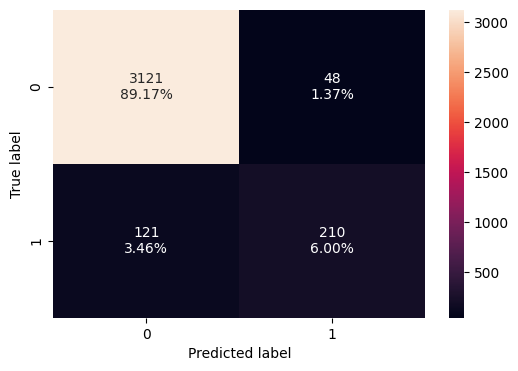

In [177]:
# Creating confusion matrix
confusion_matrix_sklearn_with_threshold(log_reg, x_train, y_train)

In [178]:
# Checking performance on test set
log_reg_model_train_perf = model_performance_classification_sklearn_with_threshold(
    log_reg, x_train, y_train
)

print("Training performance:")
log_reg_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.951714,0.634441,0.813953,0.713073


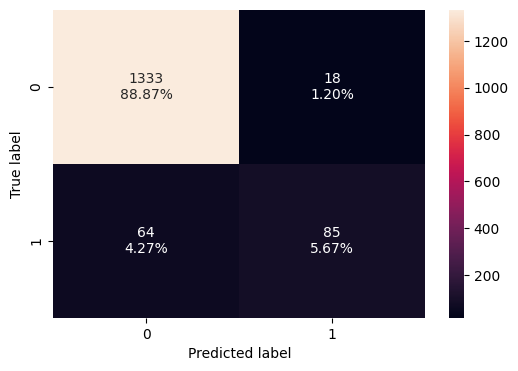

In [180]:
# creating confusion matrix
confusion_matrix_sklearn_with_threshold(log_reg, x_test, y_test)

In [182]:
log_reg_model_test_perf = model_performance_classification_sklearn_with_threshold(
    log_reg, x_test, y_test
)

print("Test set performance:")
log_reg_model_test_perf

Test set performance:


,Accuracy,Recall,Precision,F1
0,0.945333,0.57047,0.825243,0.674603


#### Observation: The Recall on the training and test sets are close in value 62% and 68% respectively, yet the model performance needs to be improved as viewed from the confusion matrix as well:

    * TP 6.20% which is less than tha 9% positive class of the dataset

#### Plotting the ROC-AUC for both training and test set
    * ROC-AUC on training set

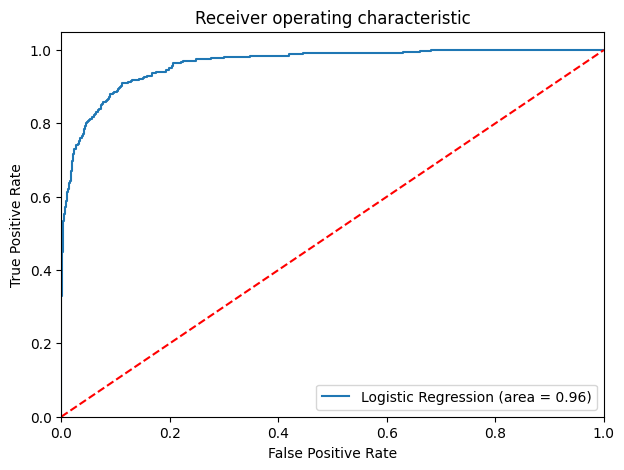

In [183]:
logit_roc_auc_train = roc_auc_score(y_train, log_reg.predict_proba(x_train)[:, 1])
fpr, tpr, thresholds = roc_curve(y_train, log_reg.predict_proba(x_train)[:, 1])
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

The AUC scores for the ROC curves of the test and train models are 0.96 and 0.97, respectively, which are close to 1. This suggests that the model performs very well but could benefit from further refinement. 
Therefore, our strategy involves adjusting the threshold and evaluating how it impacts the model's performance.

## Model Performance Improvement

1- We derive the optimal threshold from the AUC,ROC curve

In [184]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low
y_predict_train_proba = log_reg.predict_proba(x_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_predict_train_proba)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_auc_roc = thresholds[optimal_idx]
print(f'The optimal threshhold from ROC AUC curve is : {optimal_threshold_auc_roc}')

The optimal threshhold from ROC AUC curve is : 0.09213158467892742


### Checking model performance on training set

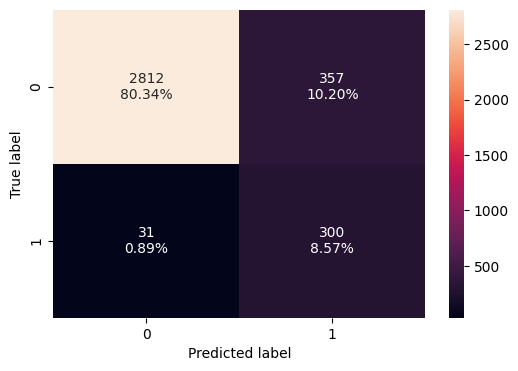

In [185]:
# Creating confusion matrix
confusion_matrix_sklearn_with_threshold(
    log_reg, x_train, y_train, threshold=optimal_threshold_auc_roc
)

## Model Performance Comparison and Final Model Selection

## Actionable Insights and Business Recommendations


* What recommedations would you suggest to the bank?

___